### You should use this one for chains (mostly what I plot in the slides) and planes testing

In [2]:
# Appropriate imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import os

# Diagonalize Hamiltonian
def get_eigen(matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    idx = eigenvalues.argsort()
    #print idx
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors
#    return eigenvalues, eigenvectors[0, :], eigenvectors[:, 0], eigenvectors[:, 1]

# Calc IPR for the adiabatic states
def _calc_IPR_for_Adiabats(eigenvectors):
    # we need to transpose this becuase now we want to loop over each element of a given eigenstate
    eigenvectors =  eigenvectors.T
    #eigenvectors = eigenvectors.A
    ipr_list = []
    for eigen in eigenvectors:
        norm = 0 
        ipr = 0
        for element in eigen:
            ipr += element ** 4
            norm += element**2
        ipr = (norm**2)/ipr
        #print "IPR", ipr
        ipr_list.append(ipr)
    return ipr_list

donor list: [0, 1]
acceptor list: [2, 3]
4


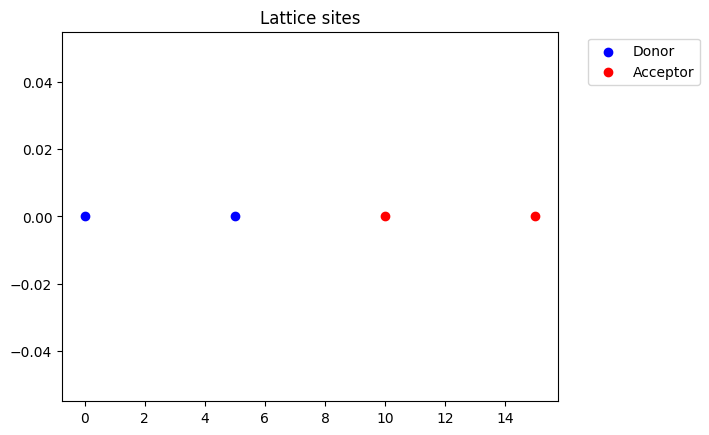

In [28]:
Ncells_x = 4 # particles along x
Ncells_y = 1  # particle along y 

lattice = 5 #lattice distance 5 Angstrom
C = 960  # meV is the interaction constant
#C = 0.0  # meV is the interaction constant
coupling_acceptor =  70 # meV 
coupling_donor = 70 #meV 

# these would be the decomp lists that I will need to input in cp2k for the diagonals
manual_donor_acc_list = False
donor = range(0,3)    # if manual_donor_acc_list is false this is not used
acceptor = range(3,6) # if manual_donor_acc_list is false this is not used

####################################################################################################
#creation cell
boxlen = Ncells_x*lattice # long cell decide boxlength
Npart = Ncells_x*Ncells_y # put 2 cells to check against manually done
rbox2 = np.zeros([Npart,2])
vbox2 = np.zeros([Npart,2])
count = 0
for i in range(Ncells_x):
    for j in range(Ncells_y): #put 2 cells to check against manually done
        rbox2[count] = (1.0/Ncells_x)*boxlen*np.array([i,j])# + boxlen*0.005*np.random.random(3)
        count += 1

#rbox = array of molecules centres of mass, first row = CoM along x-axis, second row = CoM along y-axis, length of 
#separation between molecules along x and y-axes is constant
#####################################################################################################        
    
if not manual_donor_acc_list:
    # get donor particle list very stupid way based on how the crystal is constructed
    # you could create donor and acceptor list by hand to activate the mols you want
    nparticle = len(rbox2)
    donor = []
    acceptor = []
    for indx, donor_part in enumerate(rbox2): #enumerate counts the total number of elements in rbox2
        if indx < nparticle/2:
            donor.append(indx)
        else:
            acceptor.append(indx)
print ("donor list:", donor)
print ("acceptor list:", acceptor)
print(len(rbox2))

active_tot = donor + acceptor

# I have to put an option for the active mols that I want
coms_mols = [] # coms of only the active mols
for indx, residues_list in enumerate(rbox2):
    # get active mols center of mass
    if indx in active_tot:
        #print residues_list
        coms = rbox2[indx]
        #extract CoM of electronically active molecule by indexing rbox element - takes both x and y-axis CoM
        coms_mols.append(coms)
# you could construct it already as an array from above in a smarter way
coms_mols = np.array(coms_mols)
#print rbox2
plt.title("Lattice sites")
plt.scatter(rbox2[:2,0], rbox2[:2,1], color = 'b', label = 'Donor')
plt.scatter(rbox2[2:,0], rbox2[2:,1], color = 'r', label = 'Acceptor')
plt.legend(bbox_to_anchor=(1.3,1))
#plt.scatter(coms_mols[:,0],coms_mols[:,1], color="r")

plt.show()

#print rbox2

In [29]:
#get nearest neigbours list considering the fewer active mols
connectivity = []
i = -1
for part1 in coms_mols:
    i += 1 
    j = i - 1
    for part2 in coms_mols[i:]: #looping over the same array, nothing sliced out yet
        j+=1
        if list(part1) != list(part2):
            # get neighbours within a distance "lattice"
            dist = part2 - part1 #2-element array of x-distance and y-distance
            tresh= np.sqrt(np.dot(dist,dist))
            if tresh <= lattice: #nearest neighbour = only separated by one lattice unit
                connectivity.append([active_tot[i], active_tot[j], 1]) #the one is not needed, it could be used for a better connectivity list constuction
                
                
print ("connectivity:", connectivity)
#connectivity = list of lists, where each list indicates a pair of neighbouring molecules

# creates pair of sites that form a state
states = []
for i in donor:
    for j in acceptor:
        couple = [i,j]
        states.append(couple)
        
print ("states:", states)
print ("num states:", len(states))

connectivity: [[0, 1, 1], [1, 2, 1], [2, 3, 1]]
states: [[0, 2], [0, 3], [1, 2], [1, 3]]
num states: 4


In [30]:
# creates Hamiltonian with nearest neighbour couplings and coulomb potential
hamilt = np.zeros([len(states),len(states)])
i = -1
for s1 in states:
    i +=1 
    j = i -1
    for s2 in states[i:]:
        j+=1
        if s1 != s2:
            # one index needs to be the same and the other a nearest neigbour (becuase only these states have non-zero V)
            for il in connectivity:
                if s2[0] == s1[0] and [s1[1],s2[1]] == [il[0],il[1]]:
                    hamilt[i,j] =  coupling_acceptor #set couplings acceptor part
                elif s2[1] == s1[1] and [s1[0],s2[0]] == [il[0],il[1]]:
                    hamilt[i,j] = coupling_donor #set couplings donor part
        else:
            # get distance between the particle
            r1 = rbox2[s1[0]]
            r2 = rbox2[s1[1]]
            d = r2-r1
            dist = np.sqrt(np.dot(d,d))/lattice # get distance in units of lattice spaces to be compatible with C
            ##print s1
            #print -C/dist
            hamilt[i,i] = -C/dist  
                    
        hamilt[j,i] = hamilt[i,j]

In [31]:
print(hamilt)

[[-480.   70.   70.    0.]
 [  70. -320.    0.   70.]
 [  70.    0. -960.   70.]
 [   0.   70.   70. -480.]]


[[-0.16       70.          0.         ...  0.          0.
   0.        ]
 [70.         -0.15782303 70.         ...  0.          0.
   0.        ]
 [ 0.         70.         -0.15178933 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.15178933 70.
   0.        ]
 [ 0.          0.          0.         ... 70.         -0.15782303
  70.        ]
 [ 0.          0.          0.         ...  0.         70.
  -0.16      ]]
SHAPE (1296, 1296)


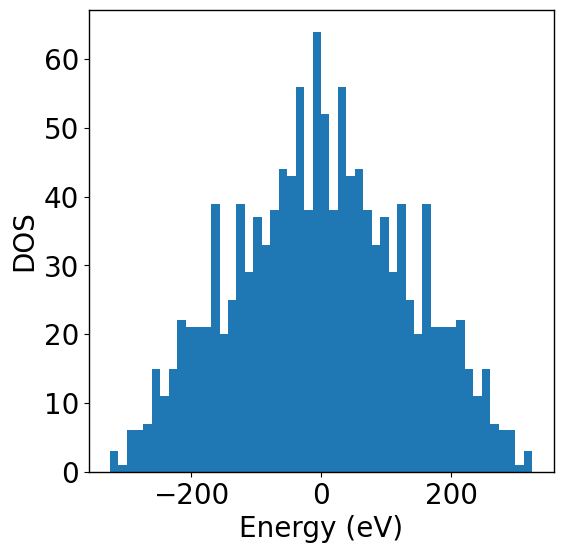

BANDWIDTH: 648.6979590652777 eV


In [40]:
#diagonalization
print(hamilt)
print("SHAPE", hamilt.shape)
eigenvalues, eigenvectors = get_eigen( hamilt )

params = {
   'axes.labelsize': 20,
   'font.size': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': False,
   'figure.figsize': [6, 6],
    'axes.linewidth' : 1
   }
rcParams.update(params)


plt.hist(eigenvalues, 50)
plt.ylabel("DOS")
plt.xlabel("Energy (eV)")
plt.show()

np.savetxt("hamilt.dat", hamilt, fmt="%10.3f")

print("BANDWIDTH:", max(eigenvalues) - min(eigenvalues), "eV")

#zero diagonals 
#np.fill_diagonal(hamilt, 0.0)
#eigenvalues, eigenvectors = get_eigen( hamilt )
#plt.hist(eigenvalues, 50)
#plt.show()

In [14]:
print donor
print acceptor

#create integration list to get donor population
def get_the_list_for_pop(list_indx, num):
    """get the index list to be used for calculation the array of the populations 
    of donor and acceptor
    list_indx : list of donor or acceptor indeces
    num : 0 if you want the first state index, 1 if you want the second
    """
    
    integration_list = []
    #loop over donor or acceptor elements
    for ind_donor in list_indx:
        pop_list = []
        #loop over states like [0,8], [0,9]...
        for ind_state, state in enumerate(states):
            # if select donor 
            if state[num] == ind_donor:
                pop_list.append(ind_state)
        integration_list.append(pop_list)
    return integration_list
    

integration_list_donor = get_the_list_for_pop(donor,0)
integration_list_acceptor = get_the_list_for_pop(acceptor,1)
print integration_list_donor
print integration_list_acceptor



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107], [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143], [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 

[-8.12665285e-01 -5.61478835e-01 -4.55321404e-01 -3.99132591e-01
 -3.73877443e-01 -3.57578873e-01 -3.40330496e-01 -3.25529413e-01
 -3.14631589e-01 -3.04583069e-01 -2.96510821e-01 -2.89645650e-01
 -2.83593314e-01 -2.75143075e-01 -2.70889085e-01 -2.66648187e-01
 -2.61749952e-01 -2.55729619e-01 -2.53041639e-01 -2.48251613e-01
 -2.43369706e-01 -2.40477529e-01 -2.36752713e-01 -2.33644219e-01
 -2.30182649e-01 -2.26613652e-01 -2.23797273e-01 -2.20101610e-01
 -2.17585350e-01 -2.14050592e-01 -2.10808390e-01 -2.08208276e-01
 -2.05688906e-01 -2.03735398e-01 -2.00309645e-01 -1.97671658e-01
 -1.95957659e-01 -1.92900677e-01 -1.90942568e-01 -1.88695693e-01
 -1.84632146e-01 -1.82267430e-01 -1.80781206e-01 -1.78577025e-01
 -1.76120870e-01 -1.74248891e-01 -1.71477521e-01 -1.69676904e-01
 -1.67394236e-01 -1.65260084e-01 -1.63188839e-01 -1.61024558e-01
 -1.59070094e-01 -1.57073651e-01 -1.55149088e-01 -1.52125547e-01
 -1.50105751e-01 -1.47833616e-01 -1.46035368e-01 -1.43774948e-01
 -1.42551181e-01 -1.39866

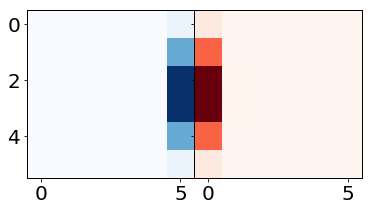

IPR donor 5.268346105714238
IPR acceptor 4.584676973487898
EIGENVAL: -0.5614788352887528
[array([7.17413086e-13, 2.20254047e-13, 1.40708199e-13, 1.40708199e-13,
       2.20254047e-13, 7.17413086e-13]), array([2.23563886e-10, 8.26829094e-11, 5.09201135e-11, 5.09201135e-11,
       8.26829094e-11, 2.23563886e-10]), array([6.33894842e-08, 2.77990288e-08, 1.66911783e-08, 1.66911783e-08,
       2.77990288e-08, 6.33894842e-08]), array([1.54801560e-05, 7.88510401e-06, 4.65789278e-06, 4.65789278e-06,
       7.88510401e-06, 1.54801560e-05]), array([0.00283021, 0.00162581, 0.00095099, 0.00095099, 0.00162581,
       0.00283021]), array([0.25161123, 0.15367496, 0.08927867, 0.08927867, 0.15367496,
       0.25161123])]


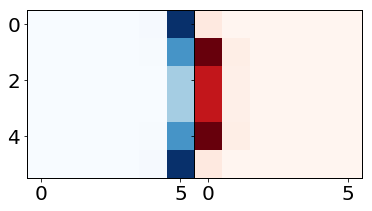

IPR donor 9.768508771468776
IPR acceptor 10.895231742720208
EIGENVAL: -0.4553214038053841
[array([6.86098776e-09, 5.83207256e-09, 6.64512755e-09, 6.64512755e-09,
       5.83207256e-09, 6.86098776e-09]), array([7.54397762e-07, 6.92172416e-07, 7.21803985e-07, 7.21803985e-07,
       6.92172416e-07, 7.54397762e-07]), array([6.70377593e-05, 6.66138920e-05, 6.36964326e-05, 6.36964326e-05,
       6.66138920e-05, 6.70377593e-05]), array([0.00420818, 0.00453291, 0.00399117, 0.00399117, 0.00453291,
       0.00420818]), array([0.11966627, 0.13961998, 0.1138127 , 0.1138127 , 0.13961998,
       0.11966627]), array([0.03662603, 0.0426179 , 0.0347253 , 0.0347253 , 0.0426179 ,
       0.03662603])]


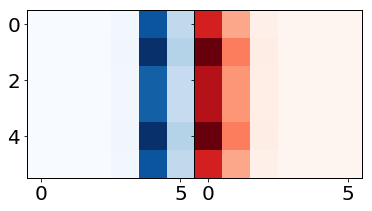

IPR donor 7.9670888239143345
IPR acceptor 10.749263482147247
EIGENVAL: -0.39913259146693403
[array([2.83429168e-08, 9.89547181e-08, 1.32772771e-07, 1.32772771e-07,
       9.89547181e-08, 2.83429168e-08]), array([1.22196066e-06, 4.95835066e-06, 7.95864392e-06, 7.95864392e-06,
       4.95835066e-06, 1.22196066e-06]), array([3.84149768e-05, 1.91321739e-04, 3.74862896e-04, 3.74862896e-04,
       1.91321739e-04, 3.84149768e-05]), array([0.00075959, 0.00505812, 0.01221713, 0.01221713, 0.00505812,
       0.00075959]), array([0.00564453, 0.05862986, 0.17379569, 0.17379569, 0.05862986,
       0.00564453]), array([0.0142766 , 0.07925691, 0.14974259, 0.14974259, 0.07925691,
       0.0142766 ])]


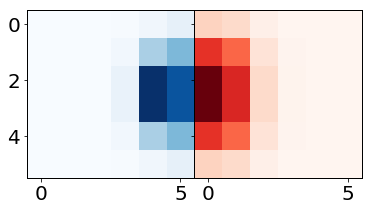

IPR donor 10.19010357867476
IPR acceptor 16.73069818832839
EIGENVAL: -0.37387744326555844
[array([2.58408488e-06, 1.22753074e-05, 2.47330244e-05, 2.47330244e-05,
       1.22753074e-05, 2.58408488e-06]), array([5.68802833e-05, 2.87202747e-04, 6.00203205e-04, 6.00203205e-04,
       2.87202747e-04, 5.68802833e-05]), array([0.00074213, 0.00403391, 0.00880618, 0.00880618, 0.00403391,
       0.00074213]), array([0.00393889, 0.02297847, 0.05250012, 0.05250012, 0.02297847,
       0.00393889]), array([0.00751696, 0.03858724, 0.06906058, 0.06906058, 0.03858724,
       0.00751696]), array([0.02574015, 0.09040626, 0.17470523, 0.17470523, 0.09040626,
       0.02574015])]


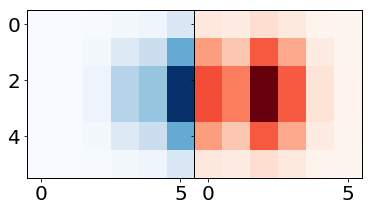

IPR donor 8.57972521585167
IPR acceptor 8.336480871628519
EIGENVAL: -0.3575788733390119
[array([9.54306557e-07, 1.57134166e-07, 1.67294185e-07, 1.67294185e-07,
       1.57134166e-07, 9.54306557e-07]), array([3.37369759e-05, 6.07131130e-06, 4.09070705e-06, 4.09070705e-06,
       6.07131130e-06, 3.37369759e-05]), array([8.52123274e-04, 2.19417729e-04, 9.96607619e-05, 9.96607619e-05,
       2.19417729e-04, 8.52123274e-04]), array([0.01473513, 0.00702219, 0.0034775 , 0.0034775 , 0.00702219,
       0.01473513]), array([0.18899305, 0.11763763, 0.07164051, 0.07164051, 0.11763763,
       0.18899305]), array([0.03325597, 0.01920061, 0.04282105, 0.04282105, 0.01920061,
       0.03325597])]


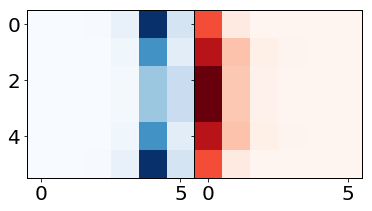

IPR donor 6.294164181309722
IPR acceptor 16.37211846320609
EIGENVAL: -0.3403304958765885
[array([2.01656958e-06, 3.12663329e-06, 3.68672166e-06, 3.68672166e-06,
       3.12663329e-06, 2.01656958e-06]), array([5.07018902e-05, 7.40054533e-05, 7.05844239e-05, 7.05844239e-05,
       7.40054533e-05, 5.07018902e-05]), array([0.00080745, 0.00109619, 0.00088026, 0.00088026, 0.00109619,
       0.00080745]), array([0.00653423, 0.00725055, 0.00656218, 0.00656218, 0.00725055,
       0.00653423]), array([0.02317171, 0.02679974, 0.0421934 , 0.0421934 , 0.02679974,
       0.02317171]), array([0.02577603, 0.10434093, 0.25438322, 0.25438322, 0.10434093,
       0.02577603])]


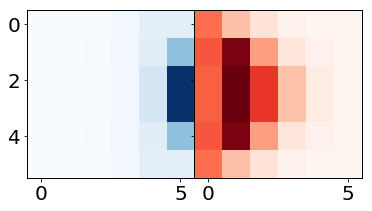

IPR donor 10.345551304559642
IPR acceptor 19.391011062727323
EIGENVAL: -0.3255294127029706
[array([6.27819190e-06, 2.11332039e-06, 7.20231499e-06, 7.20231499e-06,
       2.11332039e-06, 6.27819190e-06]), array([1.70487296e-04, 3.45630639e-05, 1.61155780e-04, 1.61155780e-04,
       3.45630639e-05, 1.70487296e-04]), array([0.00279846, 0.00037603, 0.00229312, 0.00229312, 0.00037603,
       0.00279846]), array([0.02087894, 0.00204349, 0.0155149 , 0.0155149 , 0.00204349,
       0.02087894]), array([0.06728326, 0.00852064, 0.04871375, 0.04871375, 0.00852064,
       0.06728326]), array([0.15991721, 0.07112166, 0.10015675, 0.10015675, 0.07112166,
       0.15991721])]


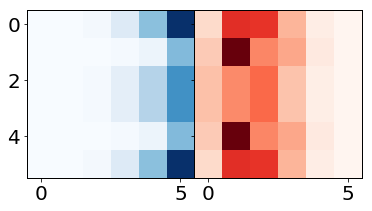

IPR donor 16.387434542607636
IPR acceptor 24.03369745219621
EIGENVAL: -0.3146315887654669
[array([8.50196589e-05, 2.53856497e-04, 3.92890956e-04, 3.92890956e-04,
       2.53856497e-04, 8.50196589e-05]), array([0.0009203 , 0.00255433, 0.00376697, 0.00376697, 0.00255433,
       0.0009203 ]), array([0.00585476, 0.01417367, 0.01837183, 0.01837183, 0.01417367,
       0.00585476]), array([0.02028538, 0.03741726, 0.03576571, 0.03576571, 0.03741726,
       0.02028538]), array([0.02559744, 0.05465077, 0.07039769, 0.07039769, 0.05465077,
       0.02559744]), array([0.02700427, 0.07070633, 0.11180152, 0.11180152, 0.07070633,
       0.02700427])]


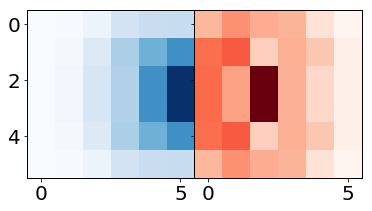

IPR donor 16.725764733700544
IPR acceptor 22.91947918697839
EIGENVAL: -0.30458306909549937
[array([0.00030934, 0.00086276, 0.00131117, 0.00131117, 0.00086276,
       0.00030934]), array([0.00241565, 0.00544129, 0.00858915, 0.00858915, 0.00544129,
       0.00241565]), array([0.01000192, 0.01294355, 0.01877601, 0.01877601, 0.01294355,
       0.01000192]), array([0.01789749, 0.03805226, 0.02235562, 0.02235562, 0.03805226,
       0.01789749]), array([0.00795582, 0.07806058, 0.04825843, 0.04825843, 0.07806058,
       0.00795582]), array([0.04984668, 0.10014402, 0.07677826, 0.07677826, 0.10014402,
       0.04984668])]


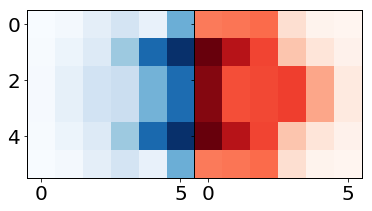

IPR donor 20.906812675932937
IPR acceptor 28.457623314383195
EIGENVAL: -0.2965108212188064
[array([0.00129303, 0.00109699, 0.0006707 , 0.0006707 , 0.00109699,
       0.00129303]), array([0.00784663, 0.00742988, 0.00467457, 0.00467457, 0.00742988,
       0.00784663]), array([0.02082646, 0.01787155, 0.01384097, 0.01384097, 0.01787155,
       0.02082646]), array([0.06610611, 0.01614976, 0.06217705, 0.06217705, 0.01614976,
       0.06610611]), array([0.04884309, 0.0351614 , 0.06957356, 0.06957356, 0.0351614 ,
       0.04884309]), array([0.06050377, 0.03717082, 0.02876367, 0.02876367, 0.03717082,
       0.06050377])]


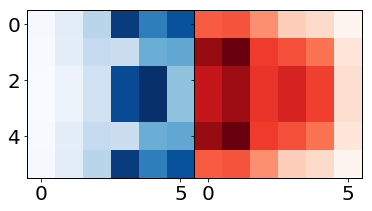

IPR donor 18.70837495558695
IPR acceptor 21.5805237563676
EIGENVAL: -0.28964565017810495
[array([1.27570862e-04, 2.28626471e-04, 4.13037928e-05, 4.13037928e-05,
       2.28626471e-04, 1.27570862e-04]), array([0.00145235, 0.00214418, 0.00065828, 0.00065828, 0.00214418,
       0.00145235]), array([0.01036383, 0.01236541, 0.00999232, 0.00999232, 0.01236541,
       0.01036383]), array([0.03235761, 0.03746859, 0.06678372, 0.06678372, 0.03746859,
       0.03235761]), array([0.08318224, 0.04255479, 0.0375548 , 0.0375548 , 0.04255479,
       0.08318224]), array([0.06018632, 0.06589224, 0.03664583, 0.03664583, 0.06589224,
       0.06018632])]


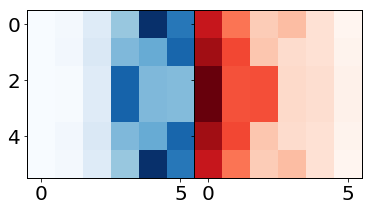

IPR donor 15.602225003745177
IPR acceptor 22.68007403971888
EIGENVAL: -0.2835933136919823
[array([1.48214770e-04, 4.04358878e-05, 1.28606944e-04, 1.28606944e-04,
       4.04358878e-05, 1.48214770e-04]), array([0.00120094, 0.00044993, 0.00085155, 0.00085155, 0.00044993,
       0.00120094]), array([0.0059263 , 0.00349508, 0.00262781, 0.00262781, 0.00349508,
       0.0059263 ]), array([0.03061305, 0.02186239, 0.01731049, 0.01731049, 0.02186239,
       0.03061305]), array([0.07298506, 0.08308181, 0.09325373, 0.09325373, 0.08308181,
       0.07298506]), array([0.04756004, 0.05328522, 0.06517935, 0.06517935, 0.05328522,
       0.04756004])]


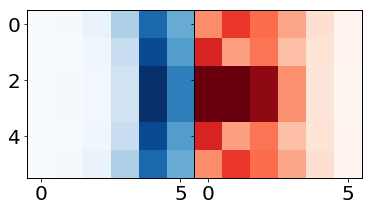

IPR donor 23.98374743073928
IPR acceptor 18.61109899617169
EIGENVAL: -0.2751430750764069
[array([0.01584376, 0.00044744, 0.00263439, 0.00263439, 0.00044744,
       0.01584376]), array([0.04417309, 0.0045026 , 0.00807731, 0.00807731, 0.0045026 ,
       0.04417309]), array([0.03296924, 0.0404174 , 0.05393502, 0.05393502, 0.0404174 ,
       0.03296924]), array([0.0601513 , 0.04616759, 0.05831211, 0.05831211, 0.04616759,
       0.0601513 ]), array([0.01073348, 0.02180195, 0.04738755, 0.04738755, 0.02180195,
       0.01073348]), array([0.01677735, 0.01472398, 0.02094443, 0.02094443, 0.01472398,
       0.01677735])]


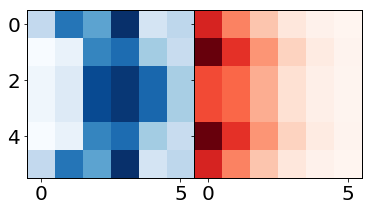

IPR donor 24.71210945425424
IPR acceptor 29.348307366034877
EIGENVAL: -0.27088908538859896
[array([0.00822506, 0.00276468, 0.00636338, 0.00636338, 0.00276468,
       0.00822506]), array([0.01464277, 0.00800936, 0.01258419, 0.01258419, 0.00800936,
       0.01464277]), array([0.03279897, 0.02968967, 0.02275891, 0.02275891, 0.02968967,
       0.03279897]), array([0.03839184, 0.03761764, 0.04329811, 0.04329811, 0.03761764,
       0.03839184]), array([0.02311272, 0.03953511, 0.08435625, 0.08435625, 0.03953511,
       0.02311272]), array([0.02453844, 0.04210709, 0.02920582, 0.02920582, 0.04210709,
       0.02453844])]


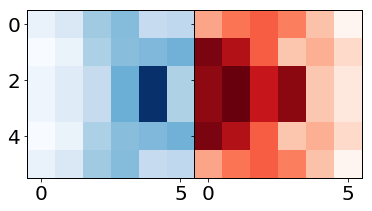

IPR donor 21.95226065649356
IPR acceptor 23.49608196106029
EIGENVAL: -0.26664818657157463
[array([0.0073768 , 0.00844505, 0.00237291, 0.00237291, 0.00844505,
       0.0073768 ]), array([0.02045282, 0.01991288, 0.01170588, 0.01170588, 0.01991288,
       0.02045282]), array([0.00959891, 0.01586362, 0.03376147, 0.03376147, 0.01586362,
       0.00959891]), array([0.01789623, 0.05829922, 0.05348358, 0.05348358, 0.05829922,
       0.01789623]), array([0.02369107, 0.02031265, 0.05349463, 0.05349463, 0.02031265,
       0.02369107]), array([0.02425017, 0.02701127, 0.09207084, 0.09207084, 0.02701127,
       0.02425017])]


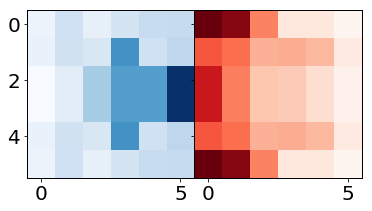

IPR donor 21.12660120780722
IPR acceptor 17.080501275885247
EIGENVAL: -0.26174995227740144
[array([0.00816781, 0.00770372, 0.00215386, 0.00215386, 0.00770372,
       0.00816781]), array([0.0373255 , 0.04255121, 0.02870861, 0.02870861, 0.04255121,
       0.0373255 ]), array([0.04198624, 0.07911055, 0.08556647, 0.08556647, 0.07911055,
       0.04198624]), array([0.0311643 , 0.03469804, 0.03210429, 0.03210429, 0.03469804,
       0.0311643 ]), array([0.0083397 , 0.02010636, 0.01747427, 0.01747427, 0.02010636,
       0.0083397 ]), array([0.00950481, 0.00597555, 0.0073587 , 0.0073587 , 0.00597555,
       0.00950481])]


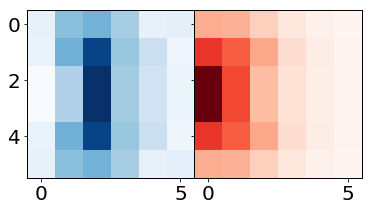

IPR donor 26.084192740439054
IPR acceptor 26.67196155568758
EIGENVAL: -0.25572961925442766
[array([0.05747243, 0.07411732, 0.02515239, 0.02515239, 0.07411732,
       0.05747243]), array([0.0271555 , 0.0458248 , 0.01934947, 0.01934947, 0.0458248 ,
       0.0271555 ]), array([0.01602642, 0.0514377 , 0.01936279, 0.01936279, 0.0514377 ,
       0.01602642]), array([0.0215771 , 0.01298539, 0.02272865, 0.02272865, 0.01298539,
       0.0215771 ]), array([0.02077569, 0.02596179, 0.01018728, 0.01018728, 0.02596179,
       0.02077569]), array([0.01429853, 0.02291183, 0.01267491, 0.01267491, 0.02291183,
       0.01429853])]


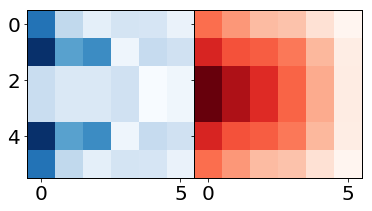

IPR donor 25.4643815551401
IPR acceptor 32.13952492573297
EIGENVAL: -0.25304163940414043
[array([0.00579701, 0.00433596, 0.00573151, 0.00573151, 0.00433596,
       0.00579701]), array([0.02137469, 0.01075821, 0.01942603, 0.01942603, 0.01075821,
       0.02137469]), array([0.03420908, 0.01537416, 0.0280654 , 0.0280654 , 0.01537416,
       0.03420908]), array([0.06835726, 0.03785315, 0.04731268, 0.04731268, 0.03785315,
       0.06835726]), array([0.06223538, 0.03438731, 0.03275139, 0.03275139, 0.03438731,
       0.06223538]), array([0.03565785, 0.01779393, 0.018579  , 0.018579  , 0.01779393,
       0.03565785])]


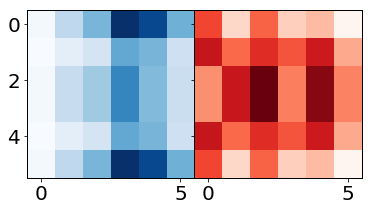

IPR donor 17.59896203758864
IPR acceptor 25.194804924117445
EIGENVAL: -0.24825161300228962
[array([0.00134969, 0.00051441, 0.00088509, 0.00088509, 0.00051441,
       0.00134969]), array([0.00949555, 0.0028385 , 0.0048654 , 0.0048654 , 0.0028385 ,
       0.00949555]), array([0.03466926, 0.00715498, 0.01250319, 0.01250319, 0.00715498,
       0.03466926]), array([0.06111926, 0.01920196, 0.03047329, 0.03047329, 0.01920196,
       0.06111926]), array([0.03256724, 0.10637805, 0.05736169, 0.05736169, 0.10637805,
       0.03256724]), array([0.06717967, 0.03876085, 0.01268191, 0.01268191, 0.03876085,
       0.06717967])]


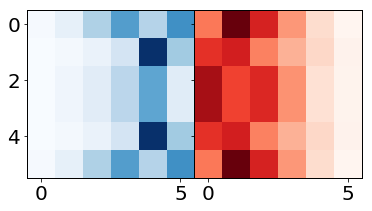

IPR donor 28.467860373816002
IPR acceptor 27.586582986405084
EIGENVAL: -0.24336970578782685
[array([0.00416521, 0.00915512, 0.01794922, 0.01794922, 0.00915512,
       0.00416521]), array([0.00909282, 0.00909849, 0.03812461, 0.03812461, 0.00909849,
       0.00909282]), array([0.03617297, 0.02854773, 0.03718661, 0.03718661, 0.02854773,
       0.03617297]), array([0.03384929, 0.06065456, 0.04517881, 0.04517881, 0.06065456,
       0.03384929]), array([0.0410366 , 0.02783506, 0.0311745 , 0.0311745 , 0.02783506,
       0.0410366 ]), array([0.025148  , 0.0275624 , 0.01806797, 0.01806797, 0.0275624 ,
       0.025148  ])]


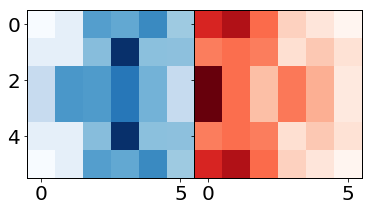

IPR donor 18.38918043668806
IPR acceptor 23.510730121281462
EIGENVAL: -0.2404775287933716
[array([0.10121088, 0.02042247, 0.01993175, 0.01993175, 0.02042247,
       0.10121088]), array([0.02956279, 0.0609795 , 0.05616538, 0.05616538, 0.0609795 ,
       0.02956279]), array([0.03417579, 0.07198112, 0.03496864, 0.03496864, 0.07198112,
       0.03417579]), array([0.00940141, 0.0209542 , 0.01206786, 0.01206786, 0.0209542 ,
       0.00940141]), array([0.00632681, 0.00482718, 0.00481456, 0.00481456, 0.00482718,
       0.00632681]), array([0.00559861, 0.0032028 , 0.00340825, 0.00340825, 0.0032028 ,
       0.00559861])]


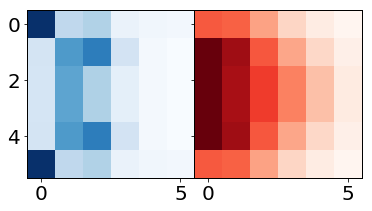

IPR donor 22.975790746675678
IPR acceptor 30.40591753485053
EIGENVAL: -0.23675271296911873
[array([0.00468436, 0.00772037, 0.00414658, 0.00414658, 0.00772037,
       0.00468436]), array([0.00883586, 0.00853065, 0.0103046 , 0.0103046 , 0.00853065,
       0.00883586]), array([0.01233532, 0.01368714, 0.02547633, 0.02547633, 0.01368714,
       0.01233532]), array([0.03111749, 0.02802852, 0.02631256, 0.02631256, 0.02802852,
       0.03111749]), array([0.05439134, 0.03769576, 0.04720788, 0.04720788, 0.03769576,
       0.05439134]), array([0.0677899 , 0.07207943, 0.0396559 , 0.0396559 , 0.07207943,
       0.0677899 ])]


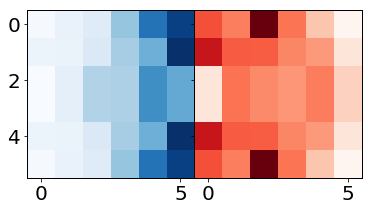

IPR donor 20.63800755362493
IPR acceptor 28.374365505743683
EIGENVAL: -0.23364421899711119
[array([0.00261449, 0.00229931, 0.00240496, 0.00240496, 0.00229931,
       0.00261449]), array([0.0079206 , 0.00618098, 0.00664955, 0.00664955, 0.00618098,
       0.0079206 ]), array([0.00980475, 0.01264117, 0.01241109, 0.01241109, 0.01264117,
       0.00980475]), array([0.0238494 , 0.03821682, 0.04094402, 0.04094402, 0.03821682,
       0.0238494 ]), array([0.04057834, 0.0735777 , 0.07884516, 0.07884516, 0.0735777 ,
       0.04057834]), array([0.04236456, 0.05111308, 0.04758403, 0.04758403, 0.05111308,
       0.04236456])]


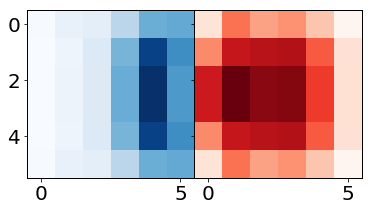

IPR donor 16.46474225189081
IPR acceptor 26.021653918793202
EIGENVAL: -0.23018264938419414
[array([0.01682257, 0.06175578, 0.10017019, 0.10017019, 0.06175578,
       0.01682257]), array([0.02241105, 0.05081947, 0.08125719, 0.08125719, 0.05081947,
       0.02241105]), array([0.01156377, 0.04334896, 0.06143898, 0.06143898, 0.04334896,
       0.01156377]), array([0.00374646, 0.01452179, 0.02276122, 0.02276122, 0.01452179,
       0.00374646]), array([0.00113621, 0.00231185, 0.00300499, 0.00300499, 0.00231185,
       0.00113621]), array([0.00076285, 0.00070388, 0.0014628 , 0.0014628 , 0.00070388,
       0.00076285])]


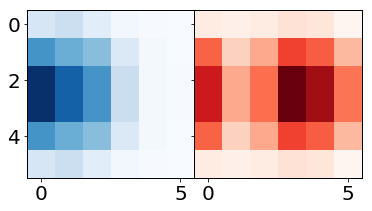

IPR donor 21.4469582713367
IPR acceptor 20.644202187637433
EIGENVAL: -0.22661365180227397
[array([0.00833417, 0.00903093, 0.00859613, 0.00859613, 0.00903093,
       0.00833417]), array([0.01440985, 0.0210965 , 0.00944409, 0.00944409, 0.0210965 ,
       0.01440985]), array([0.03105873, 0.02413279, 0.00464681, 0.00464681, 0.02413279,
       0.03105873]), array([0.02504924, 0.03784929, 0.03925836, 0.03925836, 0.03784929,
       0.02504924]), array([0.01821377, 0.05629126, 0.09813066, 0.09813066, 0.05629126,
       0.01821377]), array([0.01544298, 0.020981  , 0.05803343, 0.05803343, 0.020981  ,
       0.01544298])]


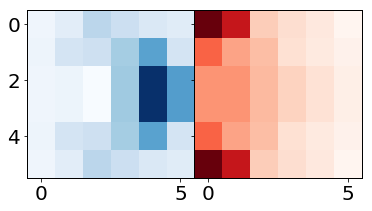

IPR donor 18.38129203032627
IPR acceptor 29.568912610718957
EIGENVAL: -0.22379727263092625
[array([0.08003838, 0.08711952, 0.03222912, 0.03222912, 0.08711952,
       0.08003838]), array([0.03919518, 0.06158714, 0.0278173 , 0.0278173 , 0.06158714,
       0.03919518]), array([0.01439383, 0.06515772, 0.03067556, 0.03067556, 0.06515772,
       0.01439383]), array([0.00818918, 0.01997738, 0.01075899, 0.01075899, 0.01997738,
       0.00818918]), array([0.00421872, 0.00445682, 0.00339594, 0.00339594, 0.00445682,
       0.00421872]), array([0.00339752, 0.00400467, 0.00338703, 0.00338703, 0.00400467,
       0.00339752])]


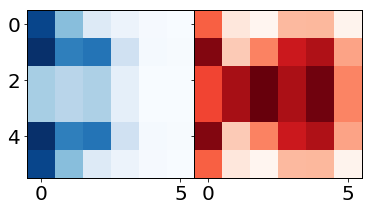

IPR donor 25.51999997332767
IPR acceptor 30.280327703673535
EIGENVAL: -0.22010161014295707
[array([0.00582126, 0.01170628, 0.0113131 , 0.0113131 , 0.01170628,
       0.00582126]), array([0.02156202, 0.01537954, 0.02120756, 0.02120756, 0.01537954,
       0.02156202]), array([0.0310529 , 0.01889193, 0.01471247, 0.01471247, 0.01889193,
       0.0310529 ]), array([0.03884779, 0.01911959, 0.02209976, 0.02209976, 0.01911959,
       0.03884779]), array([0.04464001, 0.01761029, 0.05748116, 0.05748116, 0.01761029,
       0.04464001]), array([0.04711005, 0.07591973, 0.02552457, 0.02552457, 0.07591973,
       0.04711005])]


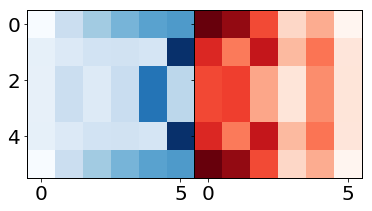

IPR donor 25.014843810629085
IPR acceptor 33.01481279384925
EIGENVAL: -0.21758535008696928
[array([0.00579114, 0.00643628, 0.00491438, 0.00491438, 0.00643628,
       0.00579114]), array([0.02144102, 0.01788129, 0.00771232, 0.00771232, 0.01788129,
       0.02144102]), array([0.0231624 , 0.02275862, 0.01068595, 0.01068595, 0.02275862,
       0.0231624 ]), array([0.03118596, 0.03567503, 0.02979491, 0.02979491, 0.03567503,
       0.03118596]), array([0.02902905, 0.05633159, 0.03349608, 0.03349608, 0.05633159,
       0.02902905]), array([0.04964976, 0.07493281, 0.03912141, 0.03912141, 0.07493281,
       0.04964976])]


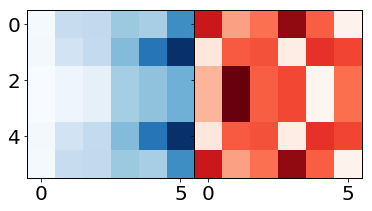

IPR donor 25.985087789430747
IPR acceptor 30.334343921967676
EIGENVAL: -0.21405059233054663
[array([0.01518618, 0.00968895, 0.00991661, 0.00991661, 0.00968895,
       0.01518618]), array([0.03330028, 0.01657375, 0.02071781, 0.02071781, 0.01657375,
       0.03330028]), array([0.04223102, 0.03089256, 0.03132435, 0.03132435, 0.03089256,
       0.04223102]), array([0.05821568, 0.03116238, 0.05873256, 0.05873256, 0.03116238,
       0.05821568]), array([0.05643702, 0.01883979, 0.04124759, 0.04124759, 0.01883979,
       0.05643702]), array([0.01201727, 0.00640463, 0.00711155, 0.00711155, 0.00640463,
       0.01201727])]


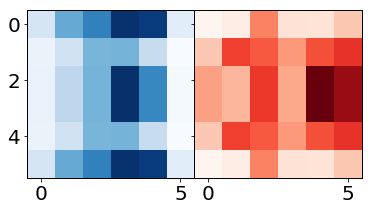

IPR donor 28.87786659794725
IPR acceptor 26.959173521456417
EIGENVAL: -0.21080838980063238
[array([0.01800766, 0.02688817, 0.01539344, 0.01539344, 0.02688817,
       0.01800766]), array([0.01005178, 0.01344969, 0.02402665, 0.02402665, 0.01344969,
       0.01005178]), array([0.0177173 , 0.01243843, 0.04709264, 0.04709264, 0.01243843,
       0.0177173 ]), array([0.02942283, 0.06122952, 0.02333611, 0.02333611, 0.06122952,
       0.02942283]), array([0.01891885, 0.03011347, 0.04623674, 0.04623674, 0.03011347,
       0.01891885]), array([0.03263284, 0.04626942, 0.02677443, 0.02677443, 0.04626942,
       0.03263284])]


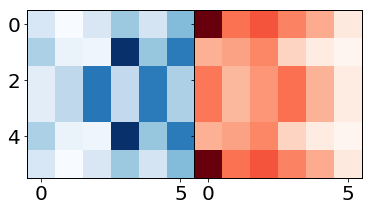

IPR donor 27.591864410501564
IPR acceptor 31.878321788528933
EIGENVAL: -0.20820827585121704
[array([0.06339732, 0.01954214, 0.05740652, 0.05740652, 0.01954214,
       0.06339732]), array([0.03185295, 0.03971737, 0.03537782, 0.03537782, 0.03971737,
       0.03185295]), array([0.04360049, 0.02138433, 0.03915722, 0.03915722, 0.02138433,
       0.04360049]), array([0.01917155, 0.01701411, 0.01698575, 0.01698575, 0.01701411,
       0.01917155]), array([0.02528922, 0.01748441, 0.01378361, 0.01378361, 0.01748441,
       0.02528922]), array([0.02131768, 0.00814493, 0.0093726 , 0.0093726 , 0.00814493,
       0.02131768])]


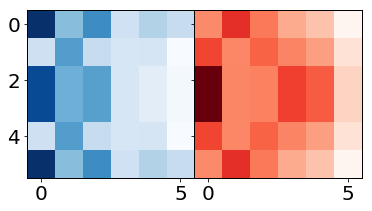

IPR donor 28.918614510496386
IPR acceptor 30.50347260297358
EIGENVAL: -0.20568890630322184
[array([0.02515977, 0.04283058, 0.05408663, 0.05408663, 0.04283058,
       0.02515977]), array([0.01703862, 0.03566943, 0.0586443 , 0.0586443 , 0.03566943,
       0.01703862]), array([0.01695639, 0.0347291 , 0.0361601 , 0.0361601 , 0.0347291 ,
       0.01695639]), array([0.02039138, 0.01188429, 0.03955414, 0.03955414, 0.01188429,
       0.02039138]), array([0.02210012, 0.0152661 , 0.01300288, 0.01300288, 0.0152661 ,
       0.02210012]), array([0.01846598, 0.02192028, 0.01613993, 0.01613993, 0.02192028,
       0.01846598])]


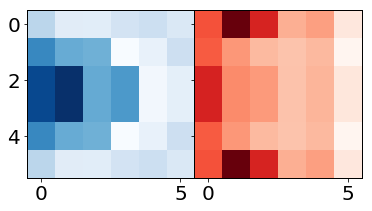

IPR donor 30.59686633722053
IPR acceptor 32.61428857264988
EIGENVAL: -0.20373539834195004
[array([0.01557649, 0.02088085, 0.02436283, 0.02436283, 0.02088085,
       0.01557649]), array([0.02315762, 0.0249675 , 0.02880355, 0.02880355, 0.0249675 ,
       0.02315762]), array([0.02565008, 0.0401836 , 0.04703208, 0.04703208, 0.0401836 ,
       0.02565008]), array([0.03999145, 0.02275568, 0.04074449, 0.04074449, 0.02275568,
       0.03999145]), array([0.01593494, 0.03550114, 0.05051546, 0.05051546, 0.03550114,
       0.01593494]), array([0.00665455, 0.0211552 , 0.01613252, 0.01613252, 0.0211552 ,
       0.00665455])]


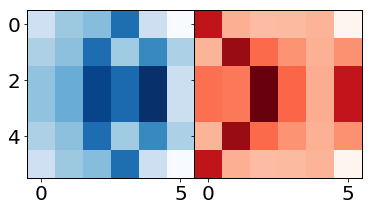

IPR donor 30.33406754840062
IPR acceptor 32.9334398011817
EIGENVAL: -0.2003096446211239
[array([0.01077844, 0.01145909, 0.01288844, 0.01288844, 0.01145909,
       0.01077844]), array([0.01987469, 0.01997862, 0.01777273, 0.01777273, 0.01997862,
       0.01987469]), array([0.02349539, 0.03607078, 0.02953318, 0.02953318, 0.03607078,
       0.02349539]), array([0.01488437, 0.02689069, 0.04172149, 0.04172149, 0.02689069,
       0.01488437]), array([0.04714001, 0.0352067 , 0.05075282, 0.05075282, 0.0352067 ,
       0.04714001]), array([0.02949244, 0.04078121, 0.03127894, 0.03127894, 0.04078121,
       0.02949244])]


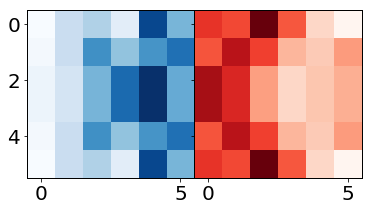

IPR donor 30.112925109813766
IPR acceptor 33.85370537046248
EIGENVAL: -0.1976716581634645
[array([0.01216594, 0.01037401, 0.01662678, 0.01662678, 0.01037401,
       0.01216594]), array([0.02304866, 0.01894866, 0.03099748, 0.03099748, 0.01894866,
       0.02304866]), array([0.02030872, 0.02924446, 0.0249273 , 0.0249273 , 0.02924446,
       0.02030872]), array([0.04607045, 0.0389143 , 0.03049566, 0.03049566, 0.0389143 ,
       0.04607045]), array([0.05696302, 0.02449819, 0.03374386, 0.03374386, 0.02449819,
       0.05696302]), array([0.02699153, 0.04369576, 0.01198521, 0.01198521, 0.04369576,
       0.02699153])]


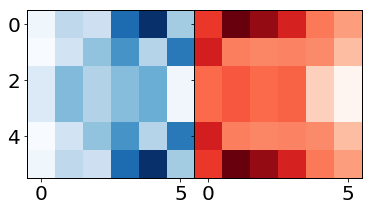

IPR donor 17.713257862763854
IPR acceptor 28.953244617519804
EIGENVAL: -0.19595765927074157
[array([0.02923982, 0.06438021, 0.0824909 , 0.0824909 , 0.06438021,
       0.02923982]), array([0.01909463, 0.05163045, 0.04257181, 0.04257181, 0.05163045,
       0.01909463]), array([0.01671132, 0.05032916, 0.08765324, 0.08765324, 0.05032916,
       0.01671132]), array([0.00339127, 0.01785865, 0.02719515, 0.02719515, 0.01785865,
       0.00339127]), array([0.00068542, 0.00247756, 0.0026837 , 0.0026837 , 0.00247756,
       0.00068542]), array([0.0002307 , 0.00053282, 0.00084318, 0.00084318, 0.00053282,
       0.0002307 ])]


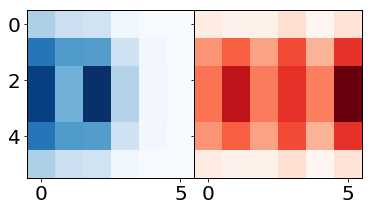

IPR donor 31.69040449927823
IPR acceptor 29.876074969644748
EIGENVAL: -0.19290067664818908
[array([0.02562034, 0.02001798, 0.04787327, 0.04787327, 0.02001798,
       0.02562034]), array([0.04742169, 0.02566402, 0.02005747, 0.02005747, 0.02566402,
       0.04742169]), array([0.04589482, 0.01433924, 0.01811093, 0.01811093, 0.01433924,
       0.04589482]), array([0.03631497, 0.02384893, 0.01758148, 0.01758148, 0.02384893,
       0.03631497]), array([0.0343693 , 0.02191049, 0.0222972 , 0.0222972 , 0.02191049,
       0.0343693 ]), array([0.03006976, 0.01993051, 0.02867759, 0.02867759, 0.01993051,
       0.03006976])]


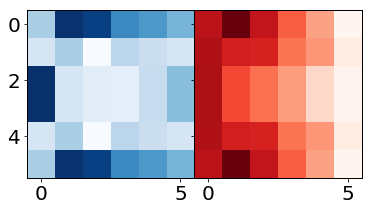

IPR donor 30.59218455430737
IPR acceptor 33.71695404186178
EIGENVAL: -0.1909425676124372
[array([0.03064731, 0.01737666, 0.0220277 , 0.0220277 , 0.01737666,
       0.03064731]), array([0.04114812, 0.02076374, 0.03940644, 0.03940644, 0.02076374,
       0.04114812]), array([0.03142431, 0.03875908, 0.03207565, 0.03207565, 0.03875908,
       0.03142431]), array([0.06131481, 0.03264595, 0.0258073 , 0.0258073 , 0.03264595,
       0.06131481]), array([0.02191178, 0.01740204, 0.01917967, 0.01917967, 0.01740204,
       0.02191178]), array([0.01805554, 0.01605907, 0.01399484, 0.01399484, 0.01605907,
       0.01805554])]


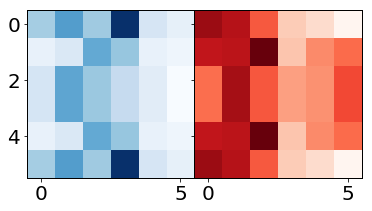

IPR donor 29.228250849965413
IPR acceptor 31.8717335992959
EIGENVAL: -0.18869569315498277
[array([0.01388052, 0.0100925 , 0.01129915, 0.01129915, 0.0100925 ,
       0.01388052]), array([0.01559017, 0.01190051, 0.01692521, 0.01692521, 0.01190051,
       0.01559017]), array([0.0268542 , 0.01499218, 0.02063781, 0.02063781, 0.01499218,
       0.0268542 ]), array([0.03774851, 0.04177583, 0.02888213, 0.02888213, 0.04177583,
       0.03774851]), array([0.03413537, 0.04439323, 0.04807593, 0.04807593, 0.04439323,
       0.03413537]), array([0.03654368, 0.05129071, 0.03498235, 0.03498235, 0.05129071,
       0.03654368])]


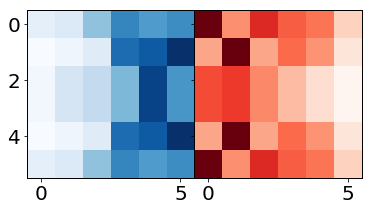

IPR donor 19.731870921218025
IPR acceptor 30.162381727429967
EIGENVAL: -0.1846321461976009
[array([0.00405194, 0.00386226, 0.0050675 , 0.0050675 , 0.00386226,
       0.00405194]), array([0.00868416, 0.00920895, 0.00686754, 0.00686754, 0.00920895,
       0.00868416]), array([0.02218035, 0.01152545, 0.00576859, 0.00576859, 0.01152545,
       0.02218035]), array([0.024571  , 0.02100579, 0.02123135, 0.02123135, 0.02100579,
       0.024571  ]), array([0.04642355, 0.04081766, 0.05722959, 0.05722959, 0.04081766,
       0.04642355]), array([0.04912982, 0.0918774 , 0.0704971 , 0.0704971 , 0.0918774 ,
       0.04912982])]


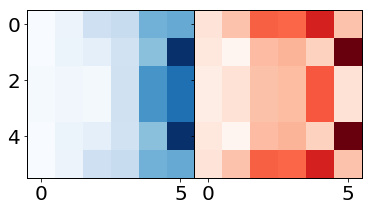

IPR donor 28.367643746037945
IPR acceptor 31.858331708279145
EIGENVAL: -0.18226743033753068
[array([0.02539954, 0.0102319 , 0.00529703, 0.00529703, 0.0102319 ,
       0.02539954]), array([0.00868955, 0.01429565, 0.01981231, 0.01981231, 0.01429565,
       0.00868955]), array([0.01661527, 0.02671554, 0.03137401, 0.03137401, 0.02671554,
       0.01661527]), array([0.04358181, 0.04780538, 0.03039427, 0.03039427, 0.04780538,
       0.04358181]), array([0.0619166 , 0.0304261 , 0.03185215, 0.03185215, 0.0304261 ,
       0.0619166 ]), array([0.0305261 , 0.04415475, 0.02091203, 0.02091203, 0.04415475,
       0.0305261 ])]


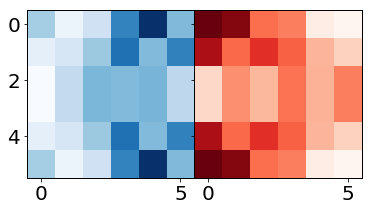

IPR donor 30.664865163537517
IPR acceptor 33.384141645286945
EIGENVAL: -0.18078120630233024
[array([0.01380771, 0.00667811, 0.01441357, 0.01441357, 0.00667811,
       0.01380771]), array([0.0206205 , 0.02087404, 0.02270893, 0.02270893, 0.02087404,
       0.0206205 ]), array([0.02628465, 0.0299695 , 0.02237471, 0.02237471, 0.0299695 ,
       0.02628465]), array([0.02867937, 0.03356885, 0.05558994, 0.05558994, 0.03356885,
       0.02867937]), array([0.02333349, 0.04806056, 0.03438388, 0.03438388, 0.04806056,
       0.02333349]), array([0.02701595, 0.03234504, 0.03929121, 0.03929121, 0.03234504,
       0.02701595])]


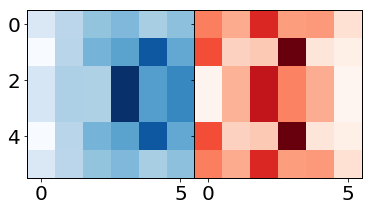

IPR donor 30.4306016739057
IPR acceptor 30.07705083057625
EIGENVAL: -0.17857702493787941
[array([0.00415748, 0.00995435, 0.01358758, 0.01358758, 0.00995435,
       0.00415748]), array([0.0204202 , 0.01649863, 0.0334481 , 0.0334481 , 0.01649863,
       0.0204202 ]), array([0.04869644, 0.02793403, 0.03616171, 0.03616171, 0.02793403,
       0.04869644]), array([0.02293431, 0.04741663, 0.0282007 , 0.0282007 , 0.04741663,
       0.02293431]), array([0.02296734, 0.03436835, 0.04208716, 0.04208716, 0.03436835,
       0.02296734]), array([0.02786575, 0.03570718, 0.02759406, 0.02759406, 0.03570718,
       0.02786575])]


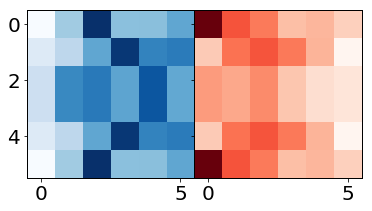

IPR donor 33.04926554643978
IPR acceptor 33.50623109029989
EIGENVAL: -0.1761208702779193
[array([0.01697041, 0.01939718, 0.01866798, 0.01866798, 0.01939718,
       0.01697041]), array([0.02193906, 0.0264853 , 0.0254433 , 0.0254433 , 0.0264853 ,
       0.02193906]), array([0.02815043, 0.02469982, 0.02103244, 0.02103244, 0.02469982,
       0.02815043]), array([0.03885881, 0.02630661, 0.0176177 , 0.0176177 , 0.02630661,
       0.03885881]), array([0.04765007, 0.02745488, 0.03884814, 0.03884814, 0.02745488,
       0.04765007]), array([0.03124412, 0.03127125, 0.03796251, 0.03796251, 0.03127125,
       0.03124412])]


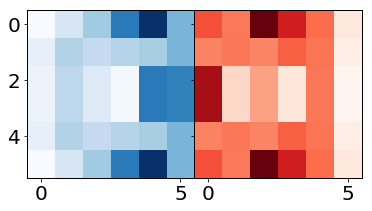

IPR donor 24.419734179323004
IPR acceptor 30.29099557961018
EIGENVAL: -0.17424889080268616
[array([0.02375363, 0.0561363 , 0.04445507, 0.04445507, 0.0561363 ,
       0.02375363]), array([0.06515742, 0.02841279, 0.02140756, 0.02140756, 0.02841279,
       0.06515742]), array([0.06822968, 0.03026119, 0.03072893, 0.03072893, 0.03026119,
       0.06822968]), array([0.02320434, 0.01211393, 0.01560373, 0.01560373, 0.01211393,
       0.02320434]), array([0.03485419, 0.01320977, 0.01942868, 0.01942868, 0.01320977,
       0.03485419]), array([0.00610864, 0.00307508, 0.00385905, 0.00385905, 0.00307508,
       0.00610864])]


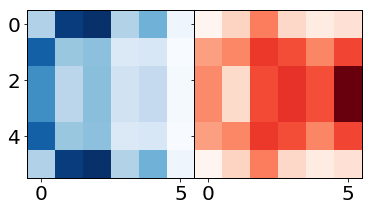

IPR donor 29.859171333310357
IPR acceptor 33.19252839117703
EIGENVAL: -0.1714775205385317
[array([0.02036658, 0.0245374 , 0.01613729, 0.01613729, 0.0245374 ,
       0.02036658]), array([0.01029879, 0.01395747, 0.02325991, 0.02325991, 0.01395747,
       0.01029879]), array([0.02593811, 0.03174572, 0.0356567 , 0.0356567 , 0.03174572,
       0.02593811]), array([0.05476766, 0.01992331, 0.04284556, 0.04284556, 0.01992331,
       0.05476766]), array([0.03789848, 0.05108131, 0.01346955, 0.01346955, 0.05108131,
       0.03789848]), array([0.03214612, 0.03088783, 0.01508222, 0.01508222, 0.03088783,
       0.03214612])]


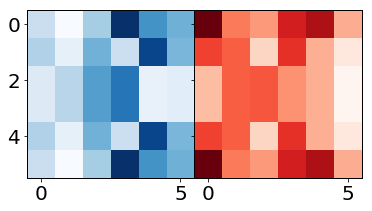

IPR donor 26.739103967441977
IPR acceptor 30.43748608868615
EIGENVAL: -0.16967690446197
[array([0.00636408, 0.00943161, 0.0094803 , 0.0094803 , 0.00943161,
       0.00636408]), array([0.00854768, 0.01497617, 0.02716822, 0.02716822, 0.01497617,
       0.00854768]), array([0.01073401, 0.02739129, 0.03384455, 0.03384455, 0.02739129,
       0.01073401]), array([0.02961473, 0.02674716, 0.04917135, 0.04917135, 0.02674716,
       0.02961473]), array([0.02624852, 0.06389366, 0.05334355, 0.05334355, 0.06389366,
       0.02624852]), array([0.04611656, 0.03390478, 0.02302178, 0.02302178, 0.03390478,
       0.04611656])]


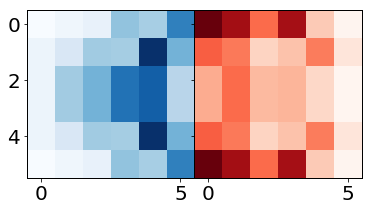

IPR donor 26.794276189721238
IPR acceptor 30.859313319480833
EIGENVAL: -0.16739423585460608
[array([0.00549367, 0.00673637, 0.00608973, 0.00608973, 0.00673637,
       0.00549367]), array([0.01462085, 0.01057713, 0.00849976, 0.00849976, 0.01057713,
       0.01462085]), array([0.03101971, 0.02062716, 0.01512042, 0.01512042, 0.02062716,
       0.03101971]), array([0.04232328, 0.04900451, 0.03263425, 0.03263425, 0.04900451,
       0.04232328]), array([0.03860361, 0.03656589, 0.03806989, 0.03806989, 0.03656589,
       0.03860361]), array([0.04486223, 0.04360133, 0.05555022, 0.05555022, 0.04360133,
       0.04486223])]


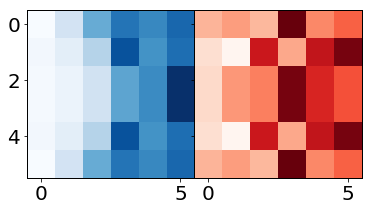

IPR donor 21.920699077413214
IPR acceptor 29.89445952321051
EIGENVAL: -0.16526008367013534
[array([0.00454357, 0.00583779, 0.00708187, 0.00708187, 0.00583779,
       0.00454357]), array([0.00717682, 0.01230908, 0.01222447, 0.01222447, 0.01230908,
       0.00717682]), array([0.01285262, 0.01355899, 0.01222731, 0.01222731, 0.01355899,
       0.01285262]), array([0.02563708, 0.03327119, 0.0221075 , 0.0221075 , 0.03327119,
       0.02563708]), array([0.03721243, 0.04373012, 0.0493136 , 0.0493136 , 0.04373012,
       0.03721243]), array([0.05181775, 0.08053065, 0.06856717, 0.06856717, 0.08053065,
       0.05181775])]


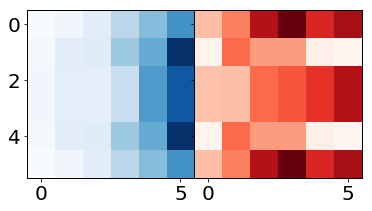

IPR donor 30.293571778731273
IPR acceptor 35.0388295284207
EIGENVAL: -0.16318883912661816
[array([0.00579714, 0.01038152, 0.01214794, 0.01214794, 0.01038152,
       0.00579714]), array([0.01665087, 0.02454919, 0.01648741, 0.01648741, 0.02454919,
       0.01665087]), array([0.04148748, 0.02594003, 0.02070089, 0.02070089, 0.02594003,
       0.04148748]), array([0.04393683, 0.02999787, 0.02479742, 0.02479742, 0.02999787,
       0.04393683]), array([0.03853661, 0.04885383, 0.03240468, 0.03240468, 0.04885383,
       0.03853661]), array([0.03611551, 0.03977046, 0.03144433, 0.03144433, 0.03977046,
       0.03611551])]


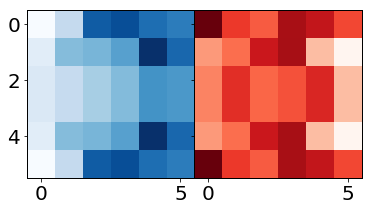

IPR donor 28.69164421040648
IPR acceptor 31.372853411198246
EIGENVAL: -0.16102455756244774
[array([0.03398564, 0.03084218, 0.02601708, 0.02601708, 0.03084218,
       0.03398564]), array([0.01925848, 0.04904981, 0.03418815, 0.03418815, 0.04904981,
       0.01925848]), array([0.01596732, 0.03451999, 0.03634274, 0.03634274, 0.03451999,
       0.01596732]), array([0.01726684, 0.03669673, 0.06567984, 0.06567984, 0.03669673,
       0.01726684]), array([0.00784001, 0.02504374, 0.02355003, 0.02355003, 0.02504374,
       0.00784001]), array([0.00776883, 0.0147571 , 0.0212255 , 0.0212255 , 0.0147571 ,
       0.00776883])]


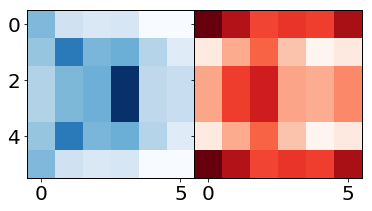

IPR donor 30.88432432014196
IPR acceptor 30.339266247905282
EIGENVAL: -0.15907009383981094
[array([0.04751474, 0.01750899, 0.01046962, 0.01046962, 0.01750899,
       0.04751474]), array([0.02006371, 0.04987549, 0.02137411, 0.02137411, 0.04987549,
       0.02006371]), array([0.03233131, 0.02492732, 0.04177842, 0.04177842, 0.02492732,
       0.03233131]), array([0.02120282, 0.02027187, 0.04635535, 0.04635535, 0.02027187,
       0.02120282]), array([0.0349202 , 0.01780918, 0.02508152, 0.02508152, 0.01780918,
       0.0349202 ]), array([0.02428444, 0.02472367, 0.01950722, 0.01950722, 0.02472367,
       0.02428444])]


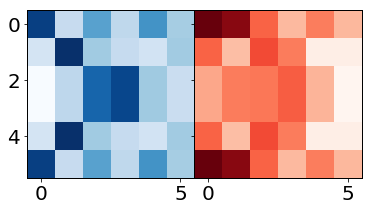

IPR donor 29.512945389733442
IPR acceptor 30.851182366275157
EIGENVAL: -0.15707365119873878
[array([0.01868395, 0.03216698, 0.02243705, 0.02243705, 0.03216698,
       0.01868395]), array([0.03151753, 0.04202796, 0.02445342, 0.02445342, 0.04202796,
       0.03151753]), array([0.05347085, 0.04403824, 0.01319903, 0.01319903, 0.04403824,
       0.05347085]), array([0.05192691, 0.02869292, 0.02682053, 0.02682053, 0.02869292,
       0.05192691]), array([0.02513153, 0.02713088, 0.00831546, 0.00831546, 0.02713088,
       0.02513153]), array([0.02858977, 0.00970846, 0.0116885 , 0.0116885 , 0.00970846,
       0.02858977])]


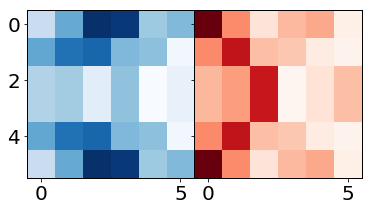

IPR donor 22.44863457455495
IPR acceptor 24.140143277759172
EIGENVAL: -0.15514908802358487
[array([0.00204148, 0.00190218, 0.00254025, 0.00254025, 0.00190218,
       0.00204148]), array([0.00549896, 0.00688352, 0.010978  , 0.010978  , 0.00688352,
       0.00549896]), array([0.01035627, 0.01765037, 0.0275835 , 0.0275835 , 0.01765037,
       0.01035627]), array([0.02776966, 0.04983613, 0.06123207, 0.06123207, 0.04983613,
       0.02776966]), array([0.04801748, 0.06494834, 0.0616315 , 0.0616315 , 0.06494834,
       0.04801748]), array([0.02401797, 0.04005113, 0.03706119, 0.03706119, 0.04005113,
       0.02401797])]


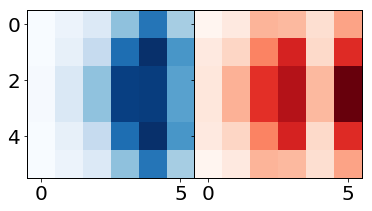

IPR donor 22.670614699371235
IPR acceptor 30.20143011258345
EIGENVAL: -0.1521255467241959
[array([0.00665463, 0.0046073 , 0.00824557, 0.00824557, 0.0046073 ,
       0.00665463]), array([0.0135754 , 0.00643567, 0.01288152, 0.01288152, 0.00643567,
       0.0135754 ]), array([0.0071268 , 0.01645402, 0.0168967 , 0.0168967 , 0.01645402,
       0.0071268 ]), array([0.02838158, 0.02566939, 0.03336104, 0.03336104, 0.02566939,
       0.02838158]), array([0.03311029, 0.04559954, 0.05021232, 0.05021232, 0.04559954,
       0.03311029]), array([0.04543463, 0.06948322, 0.07587036, 0.07587036, 0.06948322,
       0.04543463])]


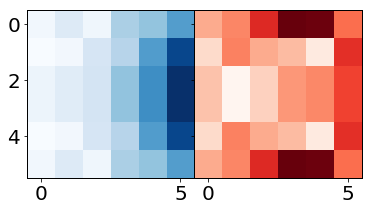

IPR donor 29.038264218323636
IPR acceptor 33.638749169700255
EIGENVAL: -0.15010575131833995
[array([0.07612067, 0.02495119, 0.01443261, 0.01443261, 0.02495119,
       0.07612067]), array([0.02418636, 0.03957228, 0.02984949, 0.02984949, 0.03957228,
       0.02418636]), array([0.02097353, 0.02314398, 0.03437795, 0.03437795, 0.02314398,
       0.02097353]), array([0.02214125, 0.03917731, 0.02631957, 0.02631957, 0.03917731,
       0.02214125]), array([0.02112477, 0.02018013, 0.02353657, 0.02353657, 0.02018013,
       0.02112477]), array([0.02683742, 0.01563606, 0.01743885, 0.01743885, 0.01563606,
       0.02683742])]


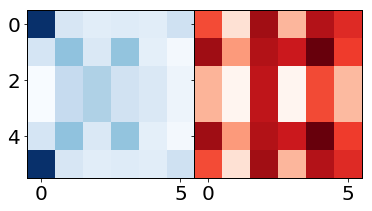

IPR donor 32.24654809651681
IPR acceptor 32.73702343852992
EIGENVAL: -0.14783361572527862
[array([0.01566342, 0.02385665, 0.01379561, 0.01379561, 0.02385665,
       0.01566342]), array([0.02369508, 0.02691903, 0.01423023, 0.01423023, 0.02691903,
       0.02369508]), array([0.03354356, 0.02327322, 0.02345813, 0.02345813, 0.02327322,
       0.03354356]), array([0.04418263, 0.03448223, 0.0263838 , 0.0263838 , 0.03448223,
       0.04418263]), array([0.03424355, 0.02794916, 0.03305164, 0.03305164, 0.02794916,
       0.03424355]), array([0.04641918, 0.01619108, 0.0386618 , 0.0386618 , 0.01619108,
       0.04641918])]


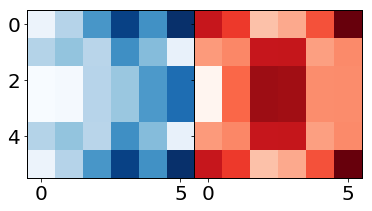

IPR donor 27.695101284210136
IPR acceptor 33.1138170161249
EIGENVAL: -0.14603536777514017
[array([0.00609528, 0.01059753, 0.00856959, 0.00856959, 0.01059753,
       0.00609528]), array([0.01265522, 0.01694364, 0.01706746, 0.01706746, 0.01694364,
       0.01265522]), array([0.02156333, 0.02779696, 0.02478675, 0.02478675, 0.02779696,
       0.02156333]), array([0.03490868, 0.02595955, 0.03044463, 0.03044463, 0.02595955,
       0.03490868]), array([0.04279257, 0.02157768, 0.06026435, 0.06026435, 0.02157768,
       0.04279257]), array([0.04308953, 0.03926495, 0.05562229, 0.05562229, 0.03926495,
       0.04308953])]


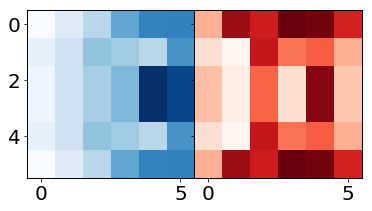

IPR donor 30.64427829608651
IPR acceptor 30.81715763220319
EIGENVAL: -0.14377494777095773
[array([0.02417289, 0.03288156, 0.03370102, 0.03370102, 0.03288156,
       0.02417289]), array([0.03145332, 0.04267608, 0.0436684 , 0.0436684 , 0.04267608,
       0.03145332]), array([0.01793178, 0.01553471, 0.02164282, 0.02164282, 0.01553471,
       0.01793178]), array([0.04117068, 0.03632603, 0.03945399, 0.03945399, 0.03632603,
       0.04117068]), array([0.01806211, 0.02732959, 0.04206793, 0.04206793, 0.02732959,
       0.01806211]), array([0.00888962, 0.00955255, 0.01348492, 0.01348492, 0.00955255,
       0.00888962])]


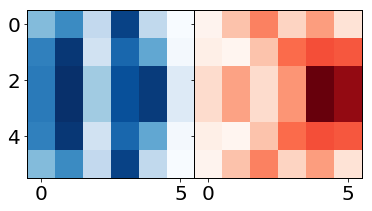

IPR donor 28.83636065565146
IPR acceptor 33.789796131975315
EIGENVAL: -0.14255118079588616
[array([0.03614267, 0.04505373, 0.04012855, 0.04012855, 0.04505373,
       0.03614267]), array([0.04582909, 0.02284021, 0.02739776, 0.02739776, 0.02284021,
       0.04582909]), array([0.06192514, 0.03456706, 0.02240823, 0.02240823, 0.03456706,
       0.06192514]), array([0.02893414, 0.02629048, 0.01915875, 0.01915875, 0.02629048,
       0.02893414]), array([0.02536142, 0.01373474, 0.0087565 , 0.0087565 , 0.01373474,
       0.02536142]), array([0.01811182, 0.01814549, 0.00521422, 0.00521422, 0.01814549,
       0.01811182])]


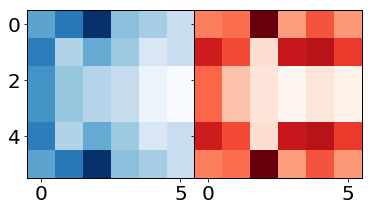

IPR donor 23.306148261727678
IPR acceptor 33.294943671098565
EIGENVAL: -0.13986606741169466
[array([0.00728937, 0.00507613, 0.01296682, 0.01296682, 0.00507613,
       0.00728937]), array([0.01400533, 0.01541773, 0.01820352, 0.01820352, 0.01541773,
       0.01400533]), array([0.02515661, 0.01839939, 0.024325  , 0.024325  , 0.01839939,
       0.02515661]), array([0.02937625, 0.02728031, 0.01735153, 0.01735153, 0.02728031,
       0.02937625]), array([0.04187287, 0.07161772, 0.03450629, 0.03450629, 0.07161772,
       0.04187287]), array([0.08750657, 0.02296145, 0.02668711, 0.02668711, 0.02296145,
       0.08750657])]


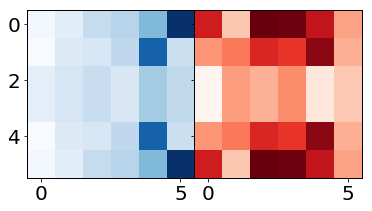

IPR donor 17.53927807957968
IPR acceptor 29.2862030920628
EIGENVAL: -0.13804743281118986
[array([0.00302484, 0.00301072, 0.00421333, 0.00421333, 0.00301072,
       0.00302484]), array([0.00536526, 0.00714368, 0.00728098, 0.00728098, 0.00714368,
       0.00536526]), array([0.01024226, 0.01379361, 0.01069436, 0.01069436, 0.01379361,
       0.01024226]), array([0.02427598, 0.02320116, 0.01541169, 0.01541169, 0.02320116,
       0.02427598]), array([0.0667854 , 0.06012183, 0.03006881, 0.03006881, 0.06012183,
       0.0667854 ]), array([0.09838727, 0.08154195, 0.03543686, 0.03543686, 0.08154195,
       0.09838727])]


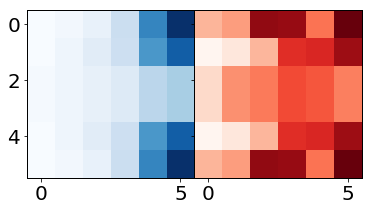

IPR donor 26.98105961827481
IPR acceptor 31.388213460152247
EIGENVAL: -0.1365301948895686
[array([0.03100824, 0.05485952, 0.0461277 , 0.0461277 , 0.05485952,
       0.03100824]), array([0.03833626, 0.03492691, 0.04180235, 0.04180235, 0.03492691,
       0.03833626]), array([0.01752457, 0.04460703, 0.03883647, 0.03883647, 0.04460703,
       0.01752457]), array([0.01475597, 0.02371102, 0.05180736, 0.05180736, 0.02371102,
       0.01475597]), array([0.00828805, 0.01850106, 0.00872011, 0.00872011, 0.01850106,
       0.00828805]), array([0.01114741, 0.00647778, 0.00856219, 0.00856219, 0.00647778,
       0.01114741])]


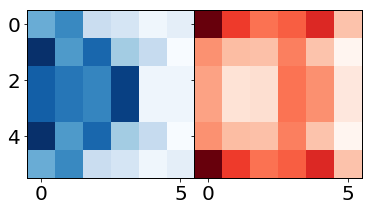

IPR donor 32.18456948894111
IPR acceptor 32.49930008041799
EIGENVAL: -0.13412000126776236
[array([0.01901817, 0.02529965, 0.01245191, 0.01245191, 0.02529965,
       0.01901817]), array([0.02143141, 0.02693814, 0.0131419 , 0.0131419 , 0.02693814,
       0.02143141]), array([0.02923178, 0.03023707, 0.02987572, 0.02987572, 0.03023707,
       0.02923178]), array([0.02805721, 0.02493951, 0.02630279, 0.02630279, 0.02493951,
       0.02805721]), array([0.04882144, 0.02600324, 0.03439406, 0.03439406, 0.02600324,
       0.04882144]), array([0.05066205, 0.02244663, 0.0307473 , 0.0307473 , 0.02244663,
       0.05066205])]


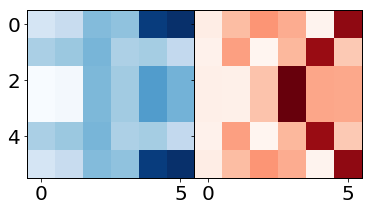

IPR donor 29.182873454867362
IPR acceptor 32.5706666280963
EIGENVAL: -0.13240110382260847
[array([0.00476089, 0.00698873, 0.00562016, 0.00562016, 0.00698873,
       0.00476089]), array([0.01389823, 0.0181418 , 0.01755453, 0.01755453, 0.0181418 ,
       0.01389823]), array([0.02574566, 0.03145734, 0.04248757, 0.04248757, 0.03145734,
       0.02574566]), array([0.03133027, 0.0356272 , 0.03593169, 0.03593169, 0.0356272 ,
       0.03133027]), array([0.0430987 , 0.04738298, 0.03731507, 0.03731507, 0.04738298,
       0.0430987 ]), array([0.04472375, 0.02531408, 0.03262135, 0.03262135, 0.02531408,
       0.04472375])]


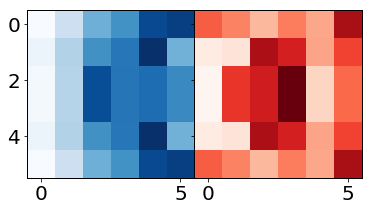

IPR donor 29.7822970160963
IPR acceptor 33.11261204879539
EIGENVAL: -0.1307185876737551
[array([0.02750348, 0.02750565, 0.03795629, 0.03795629, 0.02750565,
       0.02750348]), array([0.05522018, 0.03322584, 0.03213023, 0.03213023, 0.03322584,
       0.05522018]), array([0.04578259, 0.01884608, 0.02930491, 0.02930491, 0.01884608,
       0.04578259]), array([0.03257488, 0.04183364, 0.02359273, 0.02359273, 0.04183364,
       0.03257488]), array([0.0194582 , 0.02599034, 0.02754814, 0.02754814, 0.02599034,
       0.0194582 ]), array([0.00750737, 0.00838729, 0.00563217, 0.00563217, 0.00838729,
       0.00750737])]


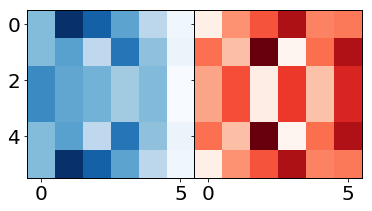

IPR donor 26.88544031446183
IPR acceptor 32.38164289210016
EIGENVAL: -0.12927360396032841
[array([0.05986399, 0.04102581, 0.04671244, 0.04671244, 0.04102581,
       0.05986399]), array([0.03963659, 0.06031578, 0.03897976, 0.03897976, 0.06031578,
       0.03963659]), array([0.0334519 , 0.02372849, 0.01575647, 0.01575647, 0.02372849,
       0.0334519 ]), array([0.01774747, 0.00940561, 0.01429341, 0.01429341, 0.00940561,
       0.01774747]), array([0.01475687, 0.0201376 , 0.01342098, 0.01342098, 0.0201376 ,
       0.01475687]), array([0.02839915, 0.01449511, 0.00787256, 0.00787256, 0.01449511,
       0.02839915])]


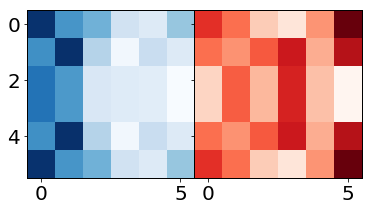

IPR donor 19.28459833064681
IPR acceptor 27.582618597531017
EIGENVAL: -0.12671532237160707
[array([0.07028856, 0.03347646, 0.0877896 , 0.0877896 , 0.03347646,
       0.07028856]), array([0.08190814, 0.02433054, 0.03770113, 0.03770113, 0.02433054,
       0.08190814]), array([0.03992621, 0.00779081, 0.01626557, 0.01626557, 0.00779081,
       0.03992621]), array([0.02381458, 0.01806492, 0.01050224, 0.01050224, 0.01806492,
       0.02381458]), array([0.01787758, 0.00856183, 0.00531255, 0.00531255, 0.00856183,
       0.01787758]), array([0.006879  , 0.00502312, 0.00448715, 0.00448715, 0.00502312,
       0.006879  ])]


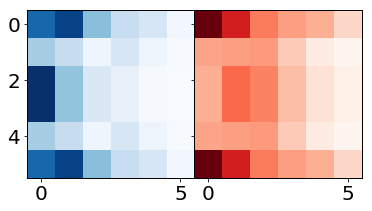

IPR donor 32.28409311118977
IPR acceptor 33.69220186525693
EIGENVAL: -0.12448473860418656
[array([0.0188312 , 0.02365743, 0.02220923, 0.02220923, 0.02365743,
       0.0188312 ]), array([0.02395912, 0.02757533, 0.03126129, 0.03126129, 0.02757533,
       0.02395912]), array([0.0277515 , 0.02961375, 0.03942913, 0.03942913, 0.02961375,
       0.0277515 ]), array([0.02295268, 0.0431472 , 0.03754613, 0.03754613, 0.0431472 ,
       0.02295268]), array([0.03878617, 0.02053717, 0.02767527, 0.02767527, 0.02053717,
       0.03878617]), array([0.04175229, 0.01718703, 0.00612808, 0.00612808, 0.01718703,
       0.04175229])]


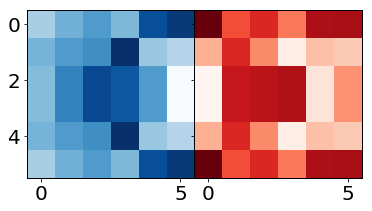

IPR donor 15.089687251544248
IPR acceptor 25.77960667553585
EIGENVAL: -0.12250890676773897
[array([0.08574722, 0.03035699, 0.10545881, 0.10545881, 0.03035699,
       0.08574722]), array([0.09209179, 0.02830085, 0.04004426, 0.04004426, 0.02830085,
       0.09209179]), array([0.04119667, 0.02551029, 0.01275291, 0.01275291, 0.02551029,
       0.04119667]), array([0.01046309, 0.01268195, 0.00757014, 0.00757014, 0.01268195,
       0.01046309]), array([0.00197361, 0.00274826, 0.00202455, 0.00202455, 0.00274826,
       0.00197361]), array([0.00044287, 0.00028616, 0.00034957, 0.00034957, 0.00028616,
       0.00044287])]


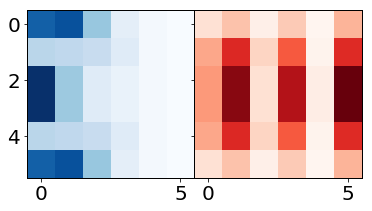

IPR donor 29.90604289797466
IPR acceptor 31.7757583139899
EIGENVAL: -0.1204115988932745
[array([0.03990791, 0.0406407 , 0.0265536 , 0.0265536 , 0.0406407 ,
       0.03990791]), array([0.01739114, 0.02204922, 0.02210136, 0.02210136, 0.02204922,
       0.01739114]), array([0.04189023, 0.05491037, 0.02185533, 0.02185533, 0.05491037,
       0.04189023]), array([0.04092961, 0.0457838 , 0.02183924, 0.02183924, 0.0457838 ,
       0.04092961]), array([0.01696945, 0.02875952, 0.01279944, 0.01279944, 0.02875952,
       0.01696945]), array([0.01823246, 0.01142763, 0.015959  , 0.015959  , 0.01142763,
       0.01823246])]


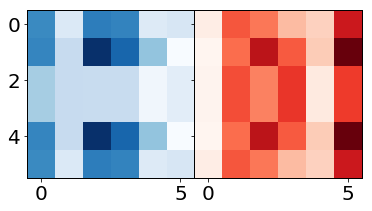

IPR donor 20.82213522863718
IPR acceptor 19.119305827488063
EIGENVAL: -0.11882119376459531
[array([0.00211483, 0.00200075, 0.00195397, 0.00195397, 0.00200075,
       0.00211483]), array([0.0084317 , 0.01051681, 0.0059855 , 0.0059855 , 0.01051681,
       0.0084317 ]), array([0.03470233, 0.04149213, 0.01572194, 0.01572194, 0.04149213,
       0.03470233]), array([0.07409147, 0.07945017, 0.02620617, 0.02620617, 0.07945017,
       0.07409147]), array([0.03680307, 0.03036498, 0.01254684, 0.01254684, 0.03036498,
       0.03680307]), array([0.05124308, 0.05391003, 0.01246423, 0.01246423, 0.05391003,
       0.05124308])]


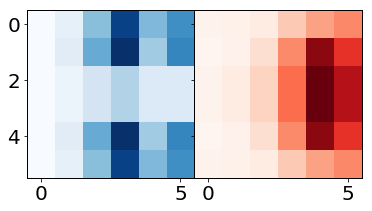

IPR donor 24.009422168279286
IPR acceptor 21.643072741552768
EIGENVAL: -0.11614460478193725
[array([0.01437585, 0.0048493 , 0.01086461, 0.01086461, 0.0048493 ,
       0.01437585]), array([0.05535994, 0.01652206, 0.03851842, 0.03851842, 0.01652206,
       0.05535994]), array([0.0640246 , 0.02607066, 0.03943904, 0.03943904, 0.02607066,
       0.0640246 ]), array([0.00805699, 0.01313   , 0.01021511, 0.01021511, 0.01313   ,
       0.00805699]), array([0.07030725, 0.02054206, 0.04803586, 0.04803586, 0.02054206,
       0.07030725]), array([0.02639926, 0.01134774, 0.02194125, 0.02194125, 0.01134774,
       0.02639926])]


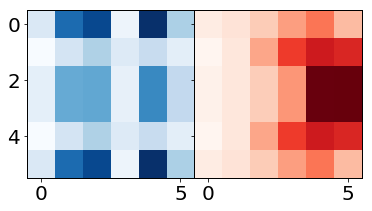

IPR donor 30.26308835808378
IPR acceptor 32.915957048359815
EIGENVAL: -0.11426710931062607
[array([0.03539332, 0.02558852, 0.02782025, 0.02782025, 0.02558852,
       0.03539332]), array([0.02400237, 0.03525351, 0.03588669, 0.03588669, 0.03525351,
       0.02400237]), array([0.04960409, 0.02169687, 0.02187864, 0.02187864, 0.02169687,
       0.04960409]), array([0.0566973 , 0.02590933, 0.00715292, 0.00715292, 0.02590933,
       0.0566973 ]), array([0.03159415, 0.02824605, 0.03163977, 0.03163977, 0.02824605,
       0.03159415]), array([0.01265075, 0.01665049, 0.01233497, 0.01233497, 0.01665049,
       0.01265075])]


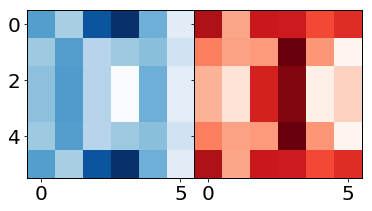

IPR donor 21.598913197967736
IPR acceptor 29.79784827001737
EIGENVAL: -0.11225617349909739
[array([0.04318372, 0.06697049, 0.06490781, 0.06490781, 0.06697049,
       0.04318372]), array([0.0279384 , 0.06047067, 0.05167115, 0.05167115, 0.06047067,
       0.0279384 ]), array([0.01514203, 0.02821103, 0.05830916, 0.05830916, 0.02821103,
       0.01514203]), array([0.01401396, 0.00755917, 0.02263958, 0.02263958, 0.00755917,
       0.01401396]), array([0.01014951, 0.00571468, 0.00948013, 0.00948013, 0.00571468,
       0.01014951]), array([0.0041219 , 0.00510803, 0.00440856, 0.00440856, 0.00510803,
       0.0041219 ])]


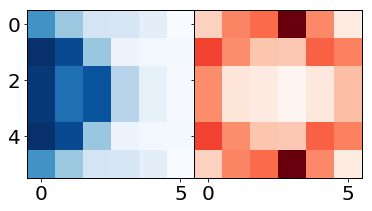

IPR donor 22.409032937163005
IPR acceptor 18.423211825839115
EIGENVAL: -0.11055218266966302
[array([0.00380419, 0.0029588 , 0.00260706, 0.00260706, 0.0029588 ,
       0.00380419]), array([0.01676691, 0.01428677, 0.00893992, 0.00893992, 0.01428677,
       0.01676691]), array([0.03801449, 0.04811271, 0.01928548, 0.01928548, 0.04811271,
       0.03801449]), array([0.05263593, 0.08404934, 0.0243028 , 0.0243028 , 0.08404934,
       0.05263593]), array([0.02030559, 0.02335009, 0.02017063, 0.02017063, 0.02335009,
       0.02030559]), array([0.02790402, 0.06546561, 0.02703967, 0.02703967, 0.06546561,
       0.02790402])]


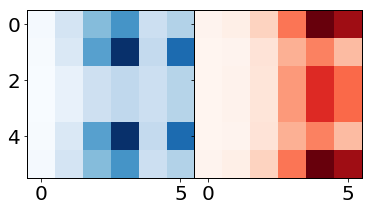

IPR donor 28.788517466157714
IPR acceptor 32.65389004107927
EIGENVAL: -0.10855811936435565
[array([0.03585317, 0.01831757, 0.00790497, 0.00790497, 0.01831757,
       0.03585317]), array([0.0304529 , 0.02272782, 0.02011108, 0.02011108, 0.02272782,
       0.0304529 ]), array([0.03090321, 0.02257494, 0.04740061, 0.04740061, 0.02257494,
       0.03090321]), array([0.05422731, 0.02332688, 0.04599734, 0.04599734, 0.02332688,
       0.05422731]), array([0.01466118, 0.02106332, 0.02363889, 0.02363889, 0.02106332,
       0.01466118]), array([0.05412693, 0.01654371, 0.01016816, 0.01016816, 0.01654371,
       0.05412693])]


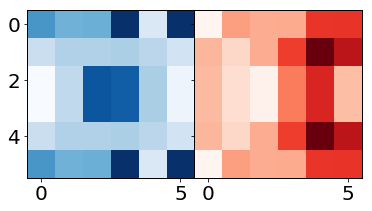

IPR donor 28.494321006264517
IPR acceptor 31.274015869513295
EIGENVAL: -0.10653647480502403
[array([0.03736925, 0.04541444, 0.05133547, 0.05133547, 0.04541444,
       0.03736925]), array([0.0263316 , 0.04354465, 0.03165286, 0.03165286, 0.04354465,
       0.0263316 ]), array([0.04334864, 0.03519655, 0.03035153, 0.03035153, 0.03519655,
       0.04334864]), array([0.04512288, 0.02246278, 0.02088617, 0.02088617, 0.02246278,
       0.04512288]), array([0.0189573 , 0.01107037, 0.01262395, 0.01262395, 0.01107037,
       0.0189573 ]), array([0.00594082, 0.00917014, 0.0092206 , 0.0092206 , 0.00917014,
       0.00594082])]


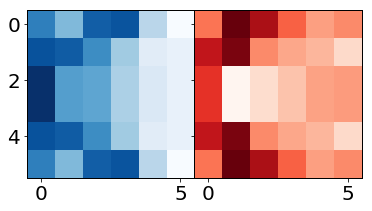

IPR donor 31.94817517199289
IPR acceptor 34.53340834028217
EIGENVAL: -0.1049785062756709
[array([0.03778499, 0.0480617 , 0.02801828, 0.02801828, 0.0480617 ,
       0.03778499]), array([0.0425949 , 0.03759164, 0.02667076, 0.02667076, 0.03759164,
       0.0425949 ]), array([0.03399364, 0.02702235, 0.01924043, 0.01924043, 0.02702235,
       0.03399364]), array([0.0273363 , 0.02185588, 0.01825836, 0.01825836, 0.02185588,
       0.0273363 ]), array([0.01994647, 0.03965215, 0.01233088, 0.01233088, 0.03965215,
       0.01994647]), array([0.02450436, 0.02173038, 0.01340652, 0.01340652, 0.02173038,
       0.02450436])]


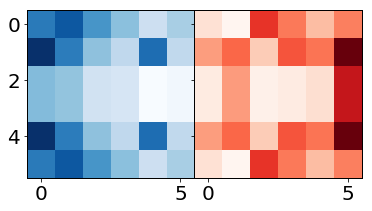

IPR donor 20.851241999825618
IPR acceptor 26.70731863203148
EIGENVAL: -0.10259771739446402
[array([0.00435421, 0.00301745, 0.00587473, 0.00587473, 0.00301745,
       0.00435421]), array([0.00883817, 0.00532446, 0.0118266 , 0.0118266 , 0.00532446,
       0.00883817]), array([0.0175763 , 0.02348618, 0.01252649, 0.01252649, 0.02348618,
       0.0175763 ]), array([0.05012331, 0.01885903, 0.02469256, 0.02469256, 0.01885903,
       0.05012331]), array([0.07920626, 0.02591789, 0.0421326 , 0.0421326 , 0.02591789,
       0.07920626]), array([0.0670584 , 0.02679919, 0.07238617, 0.07238617, 0.02679919,
       0.0670584 ])]


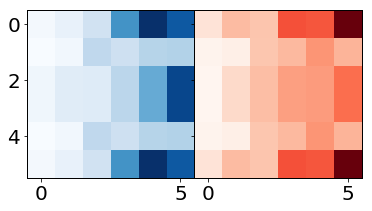

IPR donor 19.465777798529324
IPR acceptor 23.55717073006818
EIGENVAL: -0.10072364244369002
[array([0.00736359, 0.00552437, 0.00371935, 0.00371935, 0.00552437,
       0.00736359]), array([0.00676877, 0.01110923, 0.00526415, 0.00526415, 0.01110923,
       0.00676877]), array([0.0134671 , 0.01405608, 0.00864438, 0.00864438, 0.01405608,
       0.0134671 ]), array([0.02937304, 0.02969713, 0.01301348, 0.01301348, 0.02969713,
       0.02937304]), array([0.04582311, 0.05840441, 0.03445514, 0.03445514, 0.05840441,
       0.04582311]), array([0.04989083, 0.09723379, 0.06619204, 0.06619204, 0.09723379,
       0.04989083])]


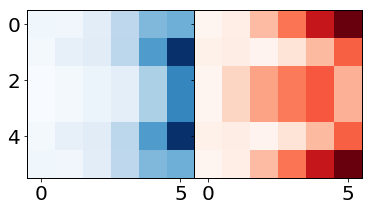

IPR donor 22.16682655418578
IPR acceptor 32.17206419760947
EIGENVAL: -0.09831456778385181
[array([0.07377076, 0.04539821, 0.02660373, 0.02660373, 0.04539821,
       0.07377076]), array([0.03290735, 0.07997029, 0.03038259, 0.03038259, 0.07997029,
       0.03290735]), array([0.02152529, 0.02898799, 0.03918601, 0.03918601, 0.02898799,
       0.02152529]), array([0.02988603, 0.03944964, 0.01774897, 0.01774897, 0.03944964,
       0.02988603]), array([0.01429772, 0.01050061, 0.00370141, 0.00370141, 0.01050061,
       0.01429772]), array([0.00257773, 0.00209573, 0.00100995, 0.00100995, 0.00209573,
       0.00257773])]


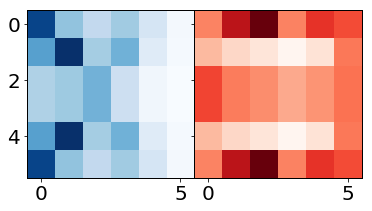

IPR donor 28.39741348710749
IPR acceptor 30.498334167197864
EIGENVAL: -0.09701184131564267
[array([0.02406439, 0.02175749, 0.02776157, 0.02776157, 0.02175749,
       0.02406439]), array([0.05540576, 0.02962396, 0.02414282, 0.02414282, 0.02962396,
       0.05540576]), array([0.05010885, 0.02712273, 0.02298778, 0.02298778, 0.02712273,
       0.05010885]), array([0.05299952, 0.03501889, 0.0264594 , 0.0264594 , 0.03501889,
       0.05299952]), array([0.0373178 , 0.00943146, 0.03251218, 0.03251218, 0.00943146,
       0.0373178 ]), array([0.01065883, 0.00391452, 0.00871202, 0.00871202, 0.00391452,
       0.01065883])]


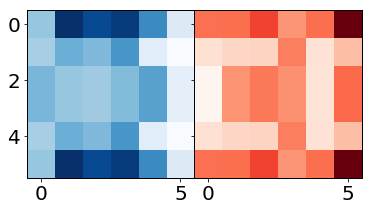

IPR donor 24.679649188474585
IPR acceptor 24.92404486281348
EIGENVAL: -0.09530840521367726
[array([0.06959203, 0.02420074, 0.05549769, 0.05549769, 0.02420074,
       0.06959203]), array([0.02013052, 0.01682327, 0.01114292, 0.01114292, 0.01682327,
       0.02013052]), array([0.06496229, 0.03042364, 0.03472174, 0.03472174, 0.03042364,
       0.06496229]), array([0.04772867, 0.01927345, 0.02827247, 0.02827247, 0.01927345,
       0.04772867]), array([0.02163064, 0.00718742, 0.00887931, 0.00887931, 0.00718742,
       0.02163064]), array([0.00963658, 0.01525475, 0.01464185, 0.01464185, 0.01525475,
       0.00963658])]


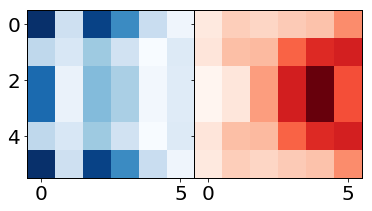

IPR donor 17.637641589786487
IPR acceptor 24.854187294103827
EIGENVAL: -0.093168314224048
[array([0.00590115, 0.00380605, 0.00557702, 0.00557702, 0.00380605,
       0.00590115]), array([0.01298393, 0.00826142, 0.00833005, 0.00833005, 0.00826142,
       0.01298393]), array([0.01318116, 0.00826889, 0.00806341, 0.00806341, 0.00826889,
       0.01318116]), array([0.01673467, 0.01845845, 0.01723697, 0.01723697, 0.01845845,
       0.01673467]), array([0.02451717, 0.06690663, 0.03500231, 0.03500231, 0.06690663,
       0.02451717]), array([0.07544553, 0.07992353, 0.09140166, 0.09140166, 0.07992353,
       0.07544553])]


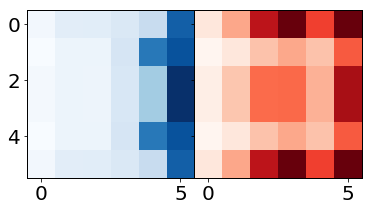

IPR donor 27.01589040377093
IPR acceptor 32.849080779409086
EIGENVAL: -0.09006008834753297
[array([0.04849031, 0.04179605, 0.03465094, 0.03465094, 0.04179605,
       0.04849031]), array([0.04834597, 0.02705308, 0.0197454 , 0.0197454 , 0.02705308,
       0.04834597]), array([0.0621804 , 0.03026184, 0.04074555, 0.04074555, 0.03026184,
       0.0621804 ]), array([0.02695911, 0.02743567, 0.03303303, 0.03303303, 0.02743567,
       0.02695911]), array([0.01046813, 0.01063782, 0.01976487, 0.01976487, 0.01063782,
       0.01046813]), array([0.00714882, 0.00769209, 0.00359092, 0.00359092, 0.00769209,
       0.00714882])]


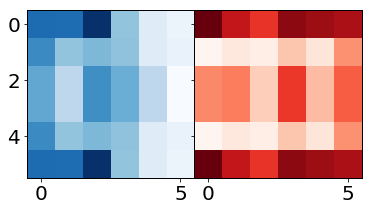

IPR donor 18.491500524455457
IPR acceptor 28.500608485490215
EIGENVAL: -0.08790808419434935
[array([0.10012688, 0.05420054, 0.03254776, 0.03254776, 0.05420054,
       0.10012688]), array([0.06048303, 0.01976206, 0.07306093, 0.07306093, 0.01976206,
       0.06048303]), array([0.01922493, 0.0209221 , 0.04150704, 0.04150704, 0.0209221 ,
       0.01922493]), array([0.01680297, 0.01467305, 0.02148397, 0.02148397, 0.01467305,
       0.01680297]), array([0.00542545, 0.00709556, 0.00710891, 0.00710891, 0.00709556,
       0.00542545]), array([0.00142029, 0.00220759, 0.00194693, 0.00194693, 0.00220759,
       0.00142029])]


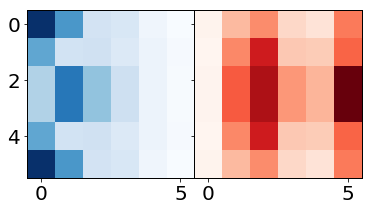

IPR donor 19.960990276981907
IPR acceptor 22.66063699726999
EIGENVAL: -0.08676647701867508
[array([0.00425092, 0.0034838 , 0.00905601, 0.00905601, 0.0034838 ,
       0.00425092]), array([0.00801658, 0.00633335, 0.01230146, 0.01230146, 0.00633335,
       0.00801658]), array([0.01560585, 0.01741066, 0.00932196, 0.00932196, 0.01741066,
       0.01560585]), array([0.0294039 , 0.03112356, 0.02110254, 0.02110254, 0.03112356,
       0.0294039 ]), array([0.0507213 , 0.06003895, 0.01921016, 0.01921016, 0.06003895,
       0.0507213 ]), array([0.08360399, 0.08349201, 0.03552301, 0.03552301, 0.08349201,
       0.08360399])]


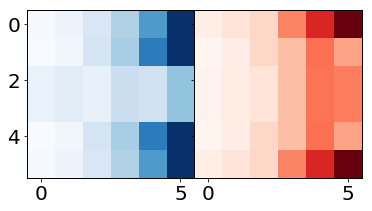

IPR donor 18.37696403289394
IPR acceptor 25.25350481290187
EIGENVAL: -0.08398229129550076
[array([0.00187925, 0.00262838, 0.00693446, 0.00693446, 0.00262838,
       0.00187925]), array([0.00610262, 0.00694386, 0.00932312, 0.00932312, 0.00694386,
       0.00610262]), array([0.01588553, 0.00442047, 0.01113478, 0.01113478, 0.00442047,
       0.01588553]), array([0.03299779, 0.01303585, 0.02449901, 0.02449901, 0.01303585,
       0.03299779]), array([0.0600293 , 0.03535501, 0.0434436 , 0.0434436 , 0.03535501,
       0.0600293 ]), array([0.10148541, 0.06017853, 0.06372302, 0.06372302, 0.06017853,
       0.10148541])]


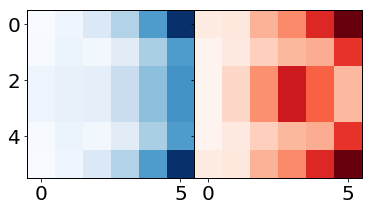

IPR donor 27.194662131785652
IPR acceptor 33.48899288111157
EIGENVAL: -0.08174908107797658
[array([0.0249857 , 0.03786584, 0.02367753, 0.02367753, 0.03786584,
       0.0249857 ]), array([0.04090703, 0.03912382, 0.03694384, 0.03694384, 0.03912382,
       0.04090703]), array([0.03423941, 0.02588521, 0.03222128, 0.03222128, 0.02588521,
       0.03423941]), array([0.04325476, 0.06992541, 0.02241048, 0.02241048, 0.06992541,
       0.04325476]), array([0.01815564, 0.01872896, 0.01715599, 0.01715599, 0.01872896,
       0.01815564]), array([0.00379178, 0.00740319, 0.00332413, 0.00332413, 0.00740319,
       0.00379178])]


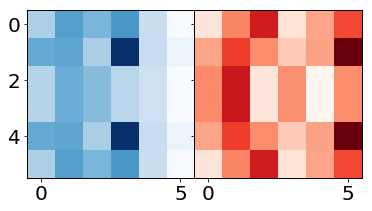

IPR donor 25.569194118893655
IPR acceptor 33.747502670127645
EIGENVAL: -0.07920776578134966
[array([0.06070298, 0.05024034, 0.0506472 , 0.0506472 , 0.05024034,
       0.06070298]), array([0.02235127, 0.05682204, 0.04385756, 0.04385756, 0.05682204,
       0.02235127]), array([0.03045009, 0.01962448, 0.04224147, 0.04224147, 0.01962448,
       0.03045009]), array([0.00838687, 0.02324559, 0.01422704, 0.01422704, 0.02324559,
       0.00838687]), array([0.02458071, 0.01306328, 0.01044839, 0.01044839, 0.01306328,
       0.02458071]), array([0.01273595, 0.01259273, 0.00378202, 0.00378202, 0.01259273,
       0.01273595])]


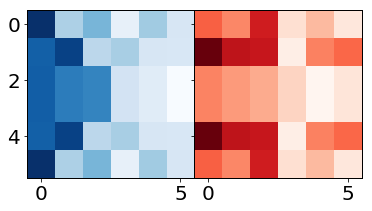

IPR donor 12.75663420329258
IPR acceptor 23.189912612965593
EIGENVAL: -0.07705437078130277
[array([0.02243811, 0.07115751, 0.12321528, 0.12321528, 0.07115751,
       0.02243811]), array([0.01918859, 0.07324311, 0.1049054 , 0.1049054 , 0.07324311,
       0.01918859]), array([0.00815111, 0.01810651, 0.03464927, 0.03464927, 0.01810651,
       0.00815111]), array([0.00289641, 0.00587618, 0.00715184, 0.00715184, 0.00587618,
       0.00289641]), array([0.00121961, 0.00306999, 0.00269081, 0.00269081, 0.00306999,
       0.00121961]), array([0.00086248, 0.00051068, 0.00066712, 0.00066712, 0.00051068,
       0.00086248])]


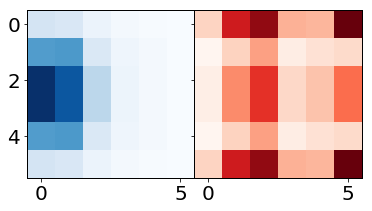

IPR donor 27.07010822814714
IPR acceptor 31.401750406623613
EIGENVAL: -0.07523586635777378
[array([0.0459868 , 0.05977566, 0.02968522, 0.02968522, 0.05977566,
       0.0459868 ]), array([0.04802196, 0.038027  , 0.01748095, 0.01748095, 0.038027  ,
       0.04802196]), array([0.04368904, 0.05100163, 0.02432404, 0.02432404, 0.05100163,
       0.04368904]), array([0.01896133, 0.03004854, 0.02506968, 0.02506968, 0.03004854,
       0.01896133]), array([0.00571387, 0.01086896, 0.01835752, 0.01835752, 0.01086896,
       0.00571387]), array([0.01129066, 0.01137235, 0.01032478, 0.01032478, 0.01137235,
       0.01129066])]


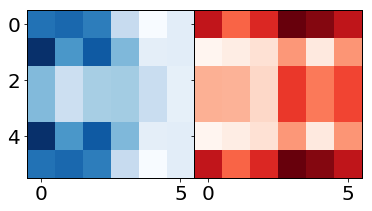

IPR donor 23.29664179634294
IPR acceptor 31.948906422046797
EIGENVAL: -0.07267971516118808
[array([0.05908743, 0.03861409, 0.06077396, 0.06077396, 0.03861409,
       0.05908743]), array([0.03185945, 0.03163975, 0.03267187, 0.03267187, 0.03163975,
       0.03185945]), array([0.06752458, 0.03253616, 0.03699618, 0.03699618, 0.03253616,
       0.06752458]), array([0.03984722, 0.02078271, 0.02289502, 0.02289502, 0.02078271,
       0.03984722]), array([0.0068805 , 0.00597457, 0.00929503, 0.00929503, 0.00597457,
       0.0068805 ]), array([0.00054239, 0.00069047, 0.00138862, 0.00138862, 0.00069047,
       0.00054239])]


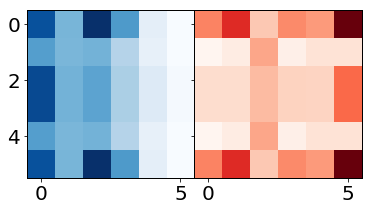

IPR donor 31.678719464155616
IPR acceptor 30.651712701341907
EIGENVAL: -0.07135933450592938
[array([0.01297679, 0.03198731, 0.0290469 , 0.0290469 , 0.03198731,
       0.01297679]), array([0.01710694, 0.03615532, 0.04280363, 0.04280363, 0.03615532,
       0.01710694]), array([0.01484202, 0.02333699, 0.0207221 , 0.0207221 , 0.02333699,
       0.01484202]), array([0.03653633, 0.02754209, 0.04981441, 0.04981441, 0.02754209,
       0.03653633]), array([0.03814195, 0.03448783, 0.02650988, 0.02650988, 0.03448783,
       0.03814195]), array([0.01993265, 0.0252909 , 0.01276598, 0.01276598, 0.0252909 ,
       0.01993265])]


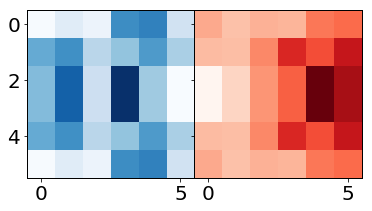

IPR donor 27.130335191780855
IPR acceptor 24.632433591897087
EIGENVAL: -0.06915167710128546
[array([0.01287085, 0.01593183, 0.02017353, 0.02017353, 0.01593183,
       0.01287085]), array([0.02436965, 0.040323  , 0.05660627, 0.05660627, 0.040323  ,
       0.02436965]), array([0.02592331, 0.03799352, 0.05220099, 0.05220099, 0.03799352,
       0.02592331]), array([0.0112811 , 0.02407326, 0.01077539, 0.01077539, 0.02407326,
       0.0112811 ]), array([0.02546446, 0.03556131, 0.06161547, 0.06161547, 0.03556131,
       0.02546446]), array([0.00721569, 0.01399246, 0.02362791, 0.02362791, 0.01399246,
       0.00721569])]


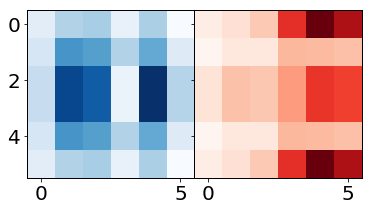

IPR donor 20.427860294610706
IPR acceptor 32.62629978211133
EIGENVAL: -0.06664295718301734
[array([0.10446751, 0.03338111, 0.02515959, 0.02515959, 0.03338111,
       0.10446751]), array([0.03255581, 0.05298223, 0.04544086, 0.04544086, 0.05298223,
       0.03255581]), array([0.02047452, 0.01116223, 0.0547064 , 0.0547064 , 0.01116223,
       0.02047452]), array([0.02067974, 0.02783759, 0.02308949, 0.02308949, 0.02783759,
       0.02067974]), array([0.01502371, 0.01778042, 0.00616888, 0.00616888, 0.01778042,
       0.01502371]), array([0.00427648, 0.00331827, 0.00149519, 0.00149519, 0.00331827,
       0.00427648])]


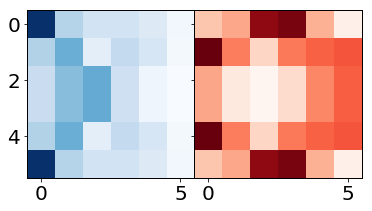

IPR donor 28.499933840742944
IPR acceptor 33.87432919145489
EIGENVAL: -0.0645296076552357
[array([0.02954595, 0.06046777, 0.03766403, 0.03766403, 0.06046777,
       0.02954595]), array([0.04850629, 0.0393131 , 0.02755898, 0.02755898, 0.0393131 ,
       0.04850629]), array([0.03860596, 0.04192161, 0.02282633, 0.02282633, 0.04192161,
       0.03860596]), array([0.02808017, 0.0301493 , 0.01695815, 0.01695815, 0.0301493 ,
       0.02808017]), array([0.01851929, 0.01809054, 0.01701036, 0.01701036, 0.01809054,
       0.01851929]), array([0.00909185, 0.01091534, 0.00477497, 0.00477497, 0.01091534,
       0.00909185])]


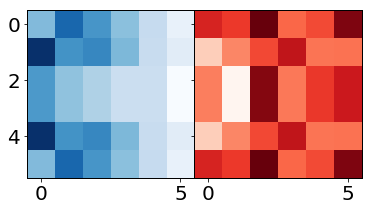

IPR donor 24.355078641510243
IPR acceptor 28.998276769791016
EIGENVAL: -0.062005109871346005
[array([0.01824124, 0.03634667, 0.05978106, 0.05978106, 0.03634667,
       0.01824124]), array([0.06398024, 0.04212455, 0.03030244, 0.03030244, 0.04212455,
       0.06398024]), array([0.0466901 , 0.02764617, 0.01503908, 0.01503908, 0.02764617,
       0.0466901 ]), array([0.05128072, 0.04114409, 0.01659493, 0.01659493, 0.04114409,
       0.05128072]), array([0.02014859, 0.01666234, 0.00650128, 0.00650128, 0.01666234,
       0.02014859]), array([0.00351802, 0.00276968, 0.0012288 , 0.0012288 , 0.00276968,
       0.00351802])]


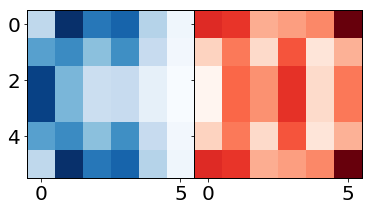

IPR donor 20.74483787692334
IPR acceptor 33.88809358722155
EIGENVAL: -0.0595645372028211
[array([0.08988795, 0.04244023, 0.03919583, 0.03919583, 0.04244023,
       0.08988795]), array([0.05866419, 0.03310479, 0.03116091, 0.03116091, 0.03310479,
       0.05866419]), array([0.04800228, 0.04155068, 0.03948128, 0.03948128, 0.04155068,
       0.04800228]), array([0.01702102, 0.00873691, 0.03387863, 0.03387863, 0.00873691,
       0.01702102]), array([0.00660901, 0.00253815, 0.00431651, 0.00431651, 0.00253815,
       0.00660901]), array([0.00181509, 0.00096208, 0.00063446, 0.00063446, 0.00096208,
       0.00181509])]


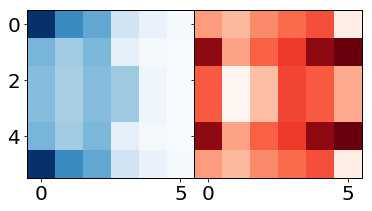

IPR donor 31.763800669803587
IPR acceptor 23.1145610983439
EIGENVAL: -0.05657855957046712
[array([0.0192271 , 0.00991024, 0.0133948 , 0.0133948 , 0.00991024,
       0.0192271 ]), array([0.02749577, 0.02349498, 0.0185478 , 0.0185478 , 0.02349498,
       0.02749577]), array([0.02559511, 0.03340323, 0.02945958, 0.02945958, 0.03340323,
       0.02559511]), array([0.027104  , 0.04373589, 0.04691501, 0.04691501, 0.04373589,
       0.027104  ]), array([0.03882928, 0.0317706 , 0.02909564, 0.02909564, 0.0317706 ,
       0.03882928]), array([0.02273026, 0.01706367, 0.04222703, 0.04222703, 0.01706367,
       0.02273026])]


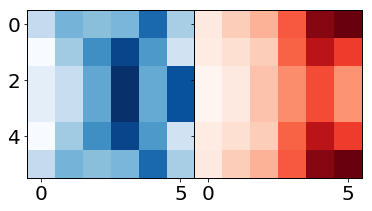

IPR donor 27.67291947192165
IPR acceptor 30.076174073073137
EIGENVAL: -0.05426098234086939
[array([0.03291264, 0.03195505, 0.01529516, 0.01529516, 0.03195505,
       0.03291264]), array([0.00920381, 0.04610521, 0.01567215, 0.01567215, 0.04610521,
       0.00920381]), array([0.03313082, 0.03062797, 0.04666743, 0.04666743, 0.03062797,
       0.03313082]), array([0.02548596, 0.06739012, 0.02783456, 0.02783456, 0.06739012,
       0.02548596]), array([0.02845622, 0.02092864, 0.00907541, 0.00907541, 0.02092864,
       0.02845622]), array([0.00775755, 0.01200141, 0.03949988, 0.03949988, 0.01200141,
       0.00775755])]


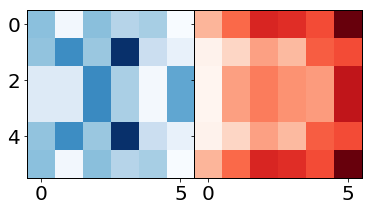

IPR donor 27.930844111319377
IPR acceptor 26.335855394021074
EIGENVAL: -0.051791372127609266
[array([0.01159865, 0.03292953, 0.05547609, 0.05547609, 0.03292953,
       0.01159865]), array([0.02100872, 0.03642952, 0.0455171 , 0.0455171 , 0.03642952,
       0.02100872]), array([0.01868519, 0.03395086, 0.03391446, 0.03391446, 0.03395086,
       0.01868519]), array([0.03070507, 0.04574552, 0.04741262, 0.04741262, 0.04574552,
       0.03070507]), array([0.01733321, 0.02943897, 0.02399065, 0.02399065, 0.02943897,
       0.01733321]), array([0.00487409, 0.00659221, 0.00439755, 0.00439755, 0.00659221,
       0.00487409])]


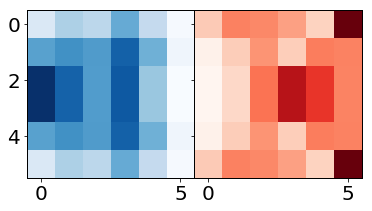

IPR donor 26.87890393480253
IPR acceptor 30.58562637688264
EIGENVAL: -0.04892635567179032
[array([0.01798599, 0.01051801, 0.01878507, 0.01878507, 0.01051801,
       0.01798599]), array([0.04546432, 0.01222042, 0.03978525, 0.03978525, 0.01222042,
       0.04546432]), array([0.05410998, 0.02219037, 0.04593007, 0.04593007, 0.02219037,
       0.05410998]), array([0.03053297, 0.01663008, 0.03288687, 0.03288687, 0.01663008,
       0.03053297]), array([0.06459256, 0.0247591 , 0.02726884, 0.02726884, 0.0247591 ,
       0.06459256]), array([0.02437392, 0.00669389, 0.00527229, 0.00527229, 0.00669389,
       0.02437392])]


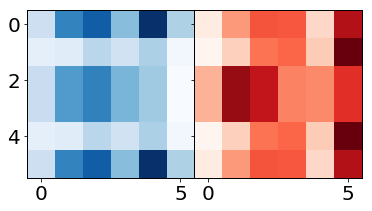

IPR donor 27.936672767228124
IPR acceptor 28.02212741611158
EIGENVAL: -0.04650203529639956
[array([0.00796103, 0.01090228, 0.00769308, 0.00769308, 0.01090228,
       0.00796103]), array([0.02619259, 0.03225758, 0.01122603, 0.01122603, 0.03225758,
       0.02619259]), array([0.04505271, 0.0495536 , 0.0208067 , 0.0208067 , 0.0495536 ,
       0.04505271]), array([0.04215483, 0.03728621, 0.02716579, 0.02716579, 0.03728621,
       0.04215483]), array([0.06068353, 0.03921447, 0.02089421, 0.02089421, 0.03921447,
       0.06068353]), array([0.02184817, 0.025926  , 0.01318119, 0.01318119, 0.025926  ,
       0.02184817])]


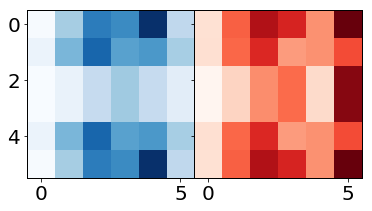

IPR donor 19.318924907572
IPR acceptor 33.523589015567254
EIGENVAL: -0.04311638267478772
[array([0.07434003, 0.05804454, 0.06580522, 0.06580522, 0.05804454,
       0.07434003]), array([0.03006306, 0.07136039, 0.04767596, 0.04767596, 0.07136039,
       0.03006306]), array([0.03522096, 0.02937593, 0.04270392, 0.04270392, 0.02937593,
       0.03522096]), array([0.01266404, 0.00994532, 0.01339368, 0.01339368, 0.00994532,
       0.01266404]), array([0.00274454, 0.00217091, 0.00266614, 0.00266614, 0.00217091,
       0.00274454]), array([0.00078364, 0.00069203, 0.0003497 , 0.0003497 , 0.00069203,
       0.00078364])]


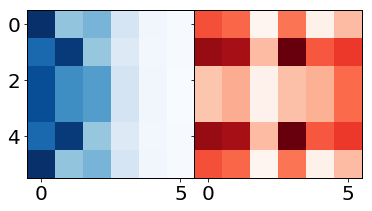

IPR donor 32.960739902324384
IPR acceptor 31.993759777101353
EIGENVAL: -0.04011079688906697
[array([0.02195193, 0.02549273, 0.02562382, 0.02562382, 0.02549273,
       0.02195193]), array([0.02462905, 0.02382098, 0.03139752, 0.03139752, 0.02382098,
       0.02462905]), array([0.02794046, 0.03728326, 0.03292359, 0.03292359, 0.03728326,
       0.02794046]), array([0.03834156, 0.03289407, 0.02015688, 0.02015688, 0.03289407,
       0.03834156]), array([0.05109833, 0.01572918, 0.02071452, 0.02071452, 0.01572918,
       0.05109833]), array([0.02639888, 0.02785362, 0.0157496 , 0.0157496 , 0.02785362,
       0.02639888])]


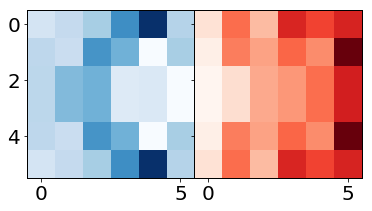

IPR donor 28.284348458196835
IPR acceptor 23.477278318320767
EIGENVAL: -0.03793480361026389
[array([0.05485849, 0.0324229 , 0.02934838, 0.02934838, 0.0324229 ,
       0.05485849]), array([0.02188058, 0.02342001, 0.00972103, 0.00972103, 0.02342001,
       0.02188058]), array([0.04645963, 0.0329546 , 0.04276436, 0.04276436, 0.0329546 ,
       0.04645963]), array([0.04262887, 0.0284291 , 0.04399002, 0.04399002, 0.0284291 ,
       0.04262887]), array([0.02209398, 0.03247315, 0.01710249, 0.01710249, 0.03247315,
       0.02209398]), array([0.01137422, 0.00523144, 0.00284672, 0.00284672, 0.00523144,
       0.01137422])]


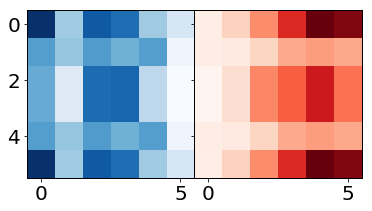

IPR donor 24.681854756064197
IPR acceptor 31.386735016122515
EIGENVAL: -0.0358525650114787
[array([0.01871206, 0.03196897, 0.05129434, 0.05129434, 0.03196897,
       0.01871206]), array([0.0346167 , 0.0486273 , 0.05814081, 0.05814081, 0.0486273 ,
       0.0346167 ]), array([0.01442634, 0.01361708, 0.01357686, 0.01357686, 0.01361708,
       0.01442634]), array([0.0269756 , 0.04018497, 0.06840967, 0.06840967, 0.04018497,
       0.0269756 ]), array([0.02290026, 0.01656466, 0.02939109, 0.02939109, 0.01656466,
       0.02290026]), array([0.00616331, 0.00170069, 0.00272928, 0.00272928, 0.00170069,
       0.00616331])]


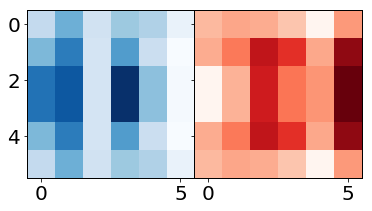

IPR donor 20.516824631285868
IPR acceptor 30.25092328411036
EIGENVAL: -0.03280318663796785
[array([0.04940089, 0.06188221, 0.0466626 , 0.0466626 , 0.06188221,
       0.04940089]), array([0.04259306, 0.09690096, 0.01946866, 0.01946866, 0.09690096,
       0.04259306]), array([0.03871366, 0.02784954, 0.03039779, 0.03039779, 0.02784954,
       0.03871366]), array([0.01070057, 0.01894327, 0.01607809, 0.01607809, 0.01894327,
       0.01070057]), array([0.0104466 , 0.01520075, 0.0069451 , 0.0069451 , 0.01520075,
       0.0104466 ]), array([0.0029403 , 0.00307386, 0.00180209, 0.00180209, 0.00307386,
       0.0029403 ])]


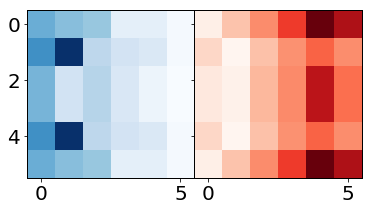

IPR donor 15.110831545195136
IPR acceptor 25.307520742434104
EIGENVAL: -0.02979734127281698
[array([0.12375093, 0.0411571 , 0.05260966, 0.05260966, 0.0411571 ,
       0.12375093]), array([0.07739526, 0.04329548, 0.06020489, 0.06020489, 0.04329548,
       0.07739526]), array([0.01648449, 0.02136585, 0.02935529, 0.02935529, 0.02136585,
       0.01648449]), array([0.00910024, 0.00811525, 0.00774485, 0.00774485, 0.00811525,
       0.00910024]), array([0.00402408, 0.00237608, 0.00140512, 0.00140512, 0.00237608,
       0.00402408]), array([0.00101617, 0.00048364, 0.00011562, 0.00011562, 0.00048364,
       0.00101617])]


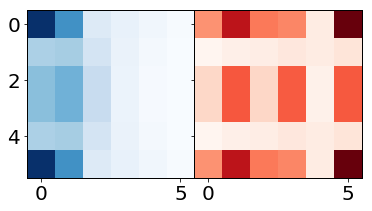

IPR donor 26.66370528129662
IPR acceptor 28.394740291569263
EIGENVAL: -0.02618969501686088
[array([0.02399746, 0.03175324, 0.01579537, 0.01579537, 0.03175324,
       0.02399746]), array([0.04410768, 0.05490958, 0.02572995, 0.02572995, 0.05490958,
       0.04410768]), array([0.04600121, 0.01932922, 0.0122756 , 0.0122756 , 0.01932922,
       0.04600121]), array([0.05506073, 0.04667447, 0.01137332, 0.01137332, 0.04667447,
       0.05506073]), array([0.03958222, 0.03678164, 0.01158726, 0.01158726, 0.03678164,
       0.03958222]), array([0.0125261 , 0.00991667, 0.00259829, 0.00259829, 0.00991667,
       0.0125261 ])]


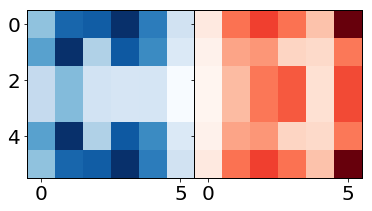

IPR donor 29.89226109839335
IPR acceptor 22.151086776400174
EIGENVAL: -0.022612890092249118
[array([0.04892969, 0.02300716, 0.03677196, 0.03677196, 0.02300716,
       0.04892969]), array([0.04670707, 0.01892135, 0.0283708 , 0.0283708 , 0.01892135,
       0.04670707]), array([0.0307864 , 0.02447222, 0.02337309, 0.02337309, 0.02447222,
       0.0307864 ]), array([0.03870008, 0.02585784, 0.03021805, 0.03021805, 0.02585784,
       0.03870008]), array([0.04920202, 0.02310848, 0.02682005, 0.02682005, 0.02310848,
       0.04920202]), array([0.01428748, 0.00598814, 0.00447813, 0.00447813, 0.00598814,
       0.01428748])]


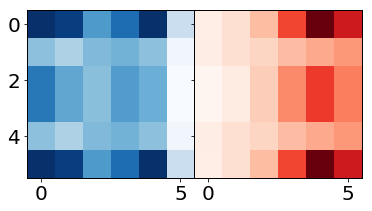

IPR donor 25.48054067009419
IPR acceptor 32.21696190938224
EIGENVAL: -0.0193384559666119
[array([0.03939537, 0.04798443, 0.05139449, 0.05139449, 0.04798443,
       0.03939537]), array([0.03707888, 0.02890644, 0.02569214, 0.02569214, 0.02890644,
       0.03707888]), array([0.05884909, 0.0570827 , 0.02211174, 0.02211174, 0.0570827 ,
       0.05884909]), array([0.02937422, 0.0366924 , 0.01456207, 0.01456207, 0.0366924 ,
       0.02937422]), array([0.01541873, 0.01600053, 0.01001664, 0.01001664, 0.01600053,
       0.01541873]), array([0.00363853, 0.00337281, 0.00242878, 0.00242878, 0.00337281,
       0.00363853])]


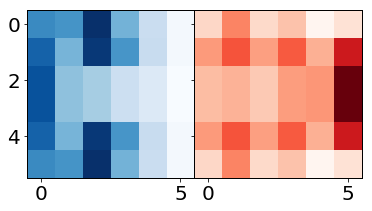

IPR donor 28.81602810879234
IPR acceptor 32.24230292376762
EIGENVAL: -0.015596385774756843
[array([0.05666097, 0.02526771, 0.03897738, 0.03897738, 0.02526771,
       0.05666097]), array([0.04904174, 0.03899895, 0.04260831, 0.04260831, 0.03899895,
       0.04904174]), array([0.02458224, 0.01647864, 0.01514251, 0.01514251, 0.01647864,
       0.02458224]), array([0.02068404, 0.04029236, 0.0278485 , 0.0278485 , 0.04029236,
       0.02068404]), array([0.03109897, 0.02848197, 0.0159227 , 0.0159227 , 0.02848197,
       0.03109897]), array([0.01271099, 0.00695825, 0.00824377, 0.00824377, 0.00695825,
       0.01271099])]


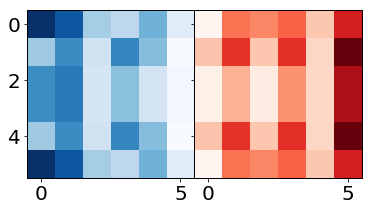

IPR donor 20.604051880127653
IPR acceptor 29.485761339545203
EIGENVAL: -0.012255228393867612
[array([0.08138585, 0.04852257, 0.05723   , 0.05723   , 0.04852257,
       0.08138585]), array([0.07060725, 0.03832195, 0.04286938, 0.04286938, 0.03832195,
       0.07060725]), array([0.03007515, 0.0249195 , 0.03139212, 0.03139212, 0.0249195 ,
       0.03007515]), array([0.02623586, 0.01014561, 0.01769513, 0.01769513, 0.01014561,
       0.02623586]), array([0.00842395, 0.00370776, 0.00315951, 0.00315951, 0.00370776,
       0.00842395]), array([0.0030604 , 0.00127334, 0.00097468, 0.00097468, 0.00127334,
       0.0030604 ])]


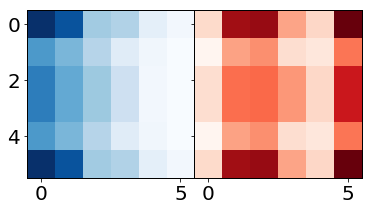

IPR donor 27.33010276343793
IPR acceptor 25.91674595106858
EIGENVAL: -0.007806942304998333
[array([0.02462609, 0.03932256, 0.02561208, 0.02561208, 0.03932256,
       0.02462609]), array([0.0419824 , 0.0449623 , 0.02353455, 0.02353455, 0.0449623 ,
       0.0419824 ]), array([0.0259256 , 0.01762855, 0.008467  , 0.008467  , 0.01762855,
       0.0259256 ]), array([0.03907237, 0.06542483, 0.01952238, 0.01952238, 0.06542483,
       0.03907237]), array([0.03618222, 0.04554431, 0.01375611, 0.01375611, 0.04554431,
       0.03618222]), array([0.01282936, 0.01261638, 0.00299092, 0.00299092, 0.01261638,
       0.01282936])]


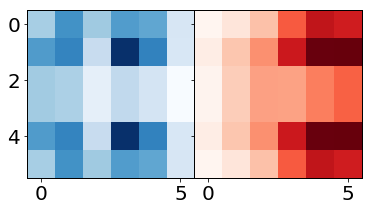

IPR donor 24.027529756987718
IPR acceptor 25.888701161072795
EIGENVAL: -0.004481058661140256
[array([0.03467578, 0.06173625, 0.05988184, 0.05988184, 0.06173625,
       0.03467578]), array([0.02851569, 0.05488121, 0.05794302, 0.05794302, 0.05488121,
       0.02851569]), array([0.02398844, 0.04244406, 0.03634233, 0.03634233, 0.04244406,
       0.02398844]), array([0.01965624, 0.01560524, 0.00970287, 0.00970287, 0.01560524,
       0.01965624]), array([0.01129815, 0.01381689, 0.01455667, 0.01455667, 0.01381689,
       0.01129815]), array([0.00478199, 0.00561442, 0.00455892, 0.00455892, 0.00561442,
       0.00478199])]


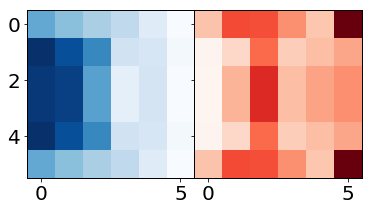

IPR donor 29.080588929269187
IPR acceptor 28.48855028194202
EIGENVAL: -0.0002966406294462783
[array([0.01698772, 0.0176652 , 0.0110718 , 0.0110718 , 0.0176652 ,
       0.01698772]), array([0.04865087, 0.04348044, 0.03449402, 0.03449402, 0.04348044,
       0.04865087]), array([0.03564368, 0.02253421, 0.03735719, 0.03735719, 0.02253421,
       0.03564368]), array([0.01403506, 0.01134607, 0.0301746 , 0.0301746 , 0.01134607,
       0.01403506]), array([0.04825156, 0.04018705, 0.0171584 , 0.0171584 , 0.04018705,
       0.04825156]), array([0.04396996, 0.01973172, 0.00726045, 0.00726045, 0.01973172,
       0.04396996])]


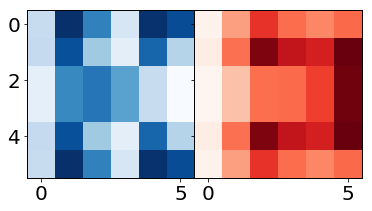

IPR donor 22.946987254750184
IPR acceptor 27.799139123157623
EIGENVAL: 0.004371759024977999
[array([0.02637049, 0.04783677, 0.07424354, 0.07424354, 0.04783677,
       0.02637049]), array([0.02003624, 0.02159553, 0.03021338, 0.03021338, 0.02159553,
       0.02003624]), array([0.02997292, 0.04569652, 0.06865903, 0.06865903, 0.04569652,
       0.02997292]), array([0.0411237 , 0.03338194, 0.02524239, 0.02524239, 0.03338194,
       0.0411237 ]), array([0.01521673, 0.00993483, 0.00508759, 0.00508759, 0.00993483,
       0.01521673]), array([0.0032692 , 0.00153744, 0.00058176, 0.00058176, 0.00153744,
       0.0032692 ])]


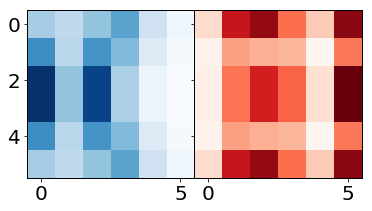

IPR donor 12.14538034594881
IPR acceptor 15.715849126361082
EIGENVAL: 0.009740068306351669
[array([0.00034334, 0.00102493, 0.00044969, 0.00044969, 0.00102493,
       0.00034334]), array([0.00118844, 0.00291406, 0.00143823, 0.00143823, 0.00291406,
       0.00118844]), array([0.01220874, 0.00466459, 0.00207147, 0.00207147, 0.00466459,
       0.01220874]), array([0.04253484, 0.015228  , 0.00218865, 0.00218865, 0.015228  ,
       0.04253484]), array([0.05566006, 0.06615942, 0.02929301, 0.02929301, 0.06615942,
       0.05566006]), array([0.0245837 , 0.09019387, 0.14785497, 0.14785497, 0.09019387,
       0.0245837 ])]


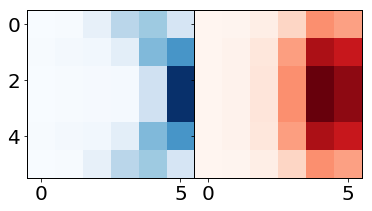

IPR donor 19.098124695255173
IPR acceptor 19.56056532775821
EIGENVAL: 0.01491910343207806
[array([0.00281548, 0.00977786, 0.00730172, 0.00730172, 0.00977786,
       0.00281548]), array([0.00524801, 0.02124991, 0.01875589, 0.01875589, 0.02124991,
       0.00524801]), array([0.05673248, 0.01801652, 0.03159444, 0.03159444, 0.01801652,
       0.05673248]), array([0.09298074, 0.01283096, 0.04906748, 0.04906748, 0.01283096,
       0.09298074]), array([0.00079862, 0.00205444, 0.04593231, 0.04593231, 0.00205444,
       0.00079862]), array([0.07784091, 0.03231456, 0.01468765, 0.01468765, 0.03231456,
       0.07784091])]


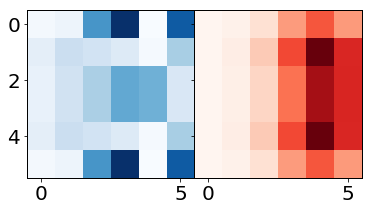

IPR donor 21.076076262059217
IPR acceptor 30.588727282160427
EIGENVAL: 0.019464576868443398
[array([0.08011782, 0.04404739, 0.04729   , 0.04729   , 0.04404739,
       0.08011782]), array([0.0198324 , 0.01856971, 0.00907953, 0.00907953, 0.01856971,
       0.0198324 ]), array([0.06329787, 0.05553277, 0.04161951, 0.04161951, 0.05553277,
       0.06329787]), array([0.04419272, 0.02707663, 0.0236206 , 0.0236206 , 0.02707663,
       0.04419272]), array([0.01405856, 0.00355331, 0.00502649, 0.00502649, 0.00355331,
       0.01405856]), array([0.00221201, 0.00031643, 0.00055626, 0.00055626, 0.00031643,
       0.00221201])]


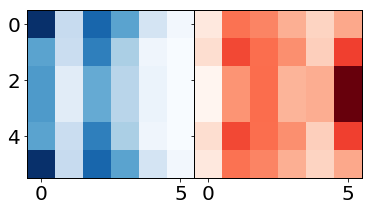

IPR donor 13.904697561001274
IPR acceptor 16.545945601228237
EIGENVAL: 0.027146643505375944
[array([0.02517061, 0.06951849, 0.09710701, 0.09710701, 0.06951849,
       0.02517061]), array([0.02797673, 0.07760274, 0.10840045, 0.10840045, 0.07760274,
       0.02797673]), array([0.01092686, 0.02886644, 0.03843256, 0.03843256, 0.02886644,
       0.01092686]), array([0.00248143, 0.00552585, 0.00633423, 0.00633423, 0.00552585,
       0.00248143]), array([0.00038171, 0.00061316, 0.00055566, 0.00055566, 0.00061316,
       0.00038171]), array([3.62896954e-05, 4.07155897e-05, 2.90615533e-05, 2.90615533e-05,
       4.07155897e-05, 3.62896954e-05])]


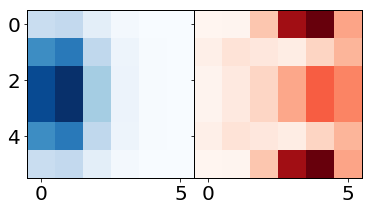

IPR donor 19.926614309826643
IPR acceptor 26.54675228856613
EIGENVAL: 0.033847480759004414
[array([0.06865433, 0.06875588, 0.0209476 , 0.0209476 , 0.06875588,
       0.06865433]), array([0.02211606, 0.00301016, 0.00722339, 0.00722339, 0.00301016,
       0.02211606]), array([0.07144661, 0.04669629, 0.04399156, 0.04399156, 0.04669629,
       0.07144661]), array([0.02154822, 0.04556353, 0.05089162, 0.05089162, 0.04556353,
       0.02154822]), array([0.00295557, 0.00875457, 0.01492209, 0.01492209, 0.00875457,
       0.00295557]), array([0.00026951, 0.00052353, 0.00172948, 0.00172948, 0.00052353,
       0.00026951])]


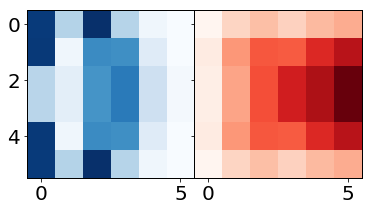

IPR donor 19.282952773796257
IPR acceptor 17.975494135514484
EIGENVAL: 0.04014315030331908
[array([0.01891464, 0.05392384, 0.08447859, 0.08447859, 0.05392384,
       0.01891464]), array([0.00640289, 0.00805265, 0.00566747, 0.00566747, 0.00805265,
       0.00640289]), array([0.02470265, 0.05790845, 0.07037452, 0.07037452, 0.05790845,
       0.02470265]), array([0.0253144 , 0.05039403, 0.05311205, 0.05311205, 0.05039403,
       0.0253144 ]), array([0.00919015, 0.01563079, 0.01169932, 0.01169932, 0.01563079,
       0.00919015]), array([0.0012545 , 0.00192807, 0.00105098, 0.00105098, 0.00192807,
       0.0012545 ])]


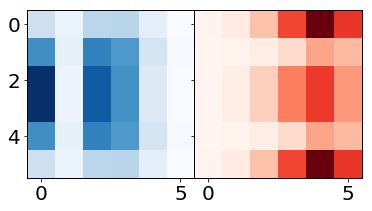

IPR donor 22.694065808507062
IPR acceptor 24.76868163478468
EIGENVAL: 0.05212695467818284
[array([0.07319684, 0.05332213, 0.03096278, 0.03096278, 0.05332213,
       0.07319684]), array([0.01634853, 0.02686459, 0.01267844, 0.01267844, 0.02686459,
       0.01634853]), array([0.06314973, 0.03762784, 0.02854659, 0.02854659, 0.03762784,
       0.06314973]), array([0.05001798, 0.01894579, 0.04544968, 0.04544968, 0.01894579,
       0.05001798]), array([0.01160947, 0.00702184, 0.01961789, 0.01961789, 0.00702184,
       0.01160947]), array([0.00101485, 0.00105936, 0.00256569, 0.00256569, 0.00105936,
       0.00101485])]


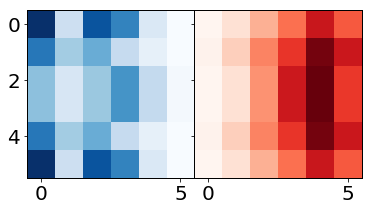

IPR donor 17.105140909874994
IPR acceptor 18.339051752779543
EIGENVAL: 0.06300857180066442
[array([0.03023153, 0.0681861 , 0.0826931 , 0.0826931 , 0.0681861 ,
       0.03023153]), array([0.02432791, 0.06515563, 0.09097643, 0.09097643, 0.06515563,
       0.02432791]), array([0.02168765, 0.03679728, 0.03815659, 0.03815659, 0.03679728,
       0.02168765]), array([0.01114013, 0.01468407, 0.00897083, 0.00897083, 0.01468407,
       0.01114013]), array([0.00229235, 0.00286982, 0.00126235, 0.00126235, 0.00286982,
       0.00229235]), array([2.12648724e-04, 2.59181308e-04, 9.63875730e-05, 9.63875730e-05,
       2.59181308e-04, 2.12648724e-04])]


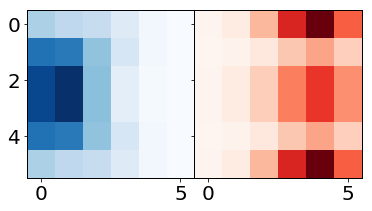

IPR donor 15.355807634545398
IPR acceptor 24.978002924547795
EIGENVAL: 0.08465364154849547
[array([0.06395622, 0.08697193, 0.04584449, 0.04584449, 0.08697193,
       0.06395622]), array([0.0721747 , 0.09705243, 0.04611724, 0.04611724, 0.09705243,
       0.0721747 ]), array([0.02502477, 0.03375884, 0.01497949, 0.01497949, 0.03375884,
       0.02502477]), array([0.00421703, 0.00582516, 0.00262789, 0.00262789, 0.00582516,
       0.00421703]), array([0.00044033, 0.00061971, 0.00030013, 0.00030013, 0.00061971,
       0.00044033]), array([2.98019211e-05, 4.01770297e-05, 1.96471535e-05, 1.96471535e-05,
       4.01770297e-05, 2.98019211e-05])]


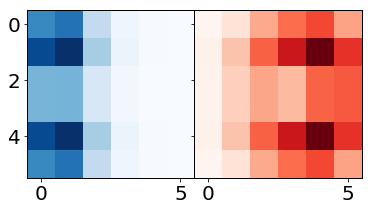

In [15]:
def get_list_population(integration_list, selected_eigen):
    """this works for both donor and acceptor 
    integration_list: pass the integration list created before for
        donor or acceptor phases
    selected_eigen: is one of the eigenvector
    
    """
    
    list_pop_donor = []
    for donor_list in integration_list:
        pop = 0.0
        for mol_ind in donor_list:
            pop += selected_eigen[mol_ind]**2
        list_pop_donor.append(pop)
    return list_pop_donor

def calc_ipr(list_pop):
    ipr = 0
    for pop in list_pop:
        ipr += pop**2
    ipr = 1/ipr
    return ipr

freq_plot = 10

last_eigen = False

#loop and select few eigenvectors
print eigenvalues[::freq_plot]
count = -1 
for eigenvec in eigenvectors.T[::freq_plot]: # neeed to be transposer
    
    if last_eigen == True:
        eigenvec = eigenvectors[:, -1]
    
    # you could loop and calculate this for all the eigenvectors
    list_pop_donor =  get_list_population(integration_list_donor, eigenvec)
    list_pop_acceptor =  get_list_population(integration_list_acceptor, eigenvec)
    ipr_donor = calc_ipr(list_pop_donor)
    ipr_acceptor = calc_ipr(list_pop_acceptor)
    print "IPR donor", ipr_donor
    print "IPR acceptor", ipr_acceptor
    
    count += 1 
    print "EIGENVAL:", eigenvalues[freq_plot*count]
    
    #test if populations sum to 1, acceptor population should sum to -1 you need to change sign
    #print np.sum(list_pop_donor)
    #print np.sum(list_pop_acceptor)
    
    # plot after mpping onto 2D grid
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
    fig.subplots_adjust(wspace=0)
    ax1 = axs[0]
    n= Ncells_y # site along one dimension
    array_pop = np.array(list_pop_donor)
    chunks_donor = [array_pop[i:i + n] for i in xrange(0, len(array_pop), n)]
    #print np.array(chunks)
    print chunks_donor
    ax1.imshow(np.array(chunks_donor).T, cmap="Blues")
    
    ax2 = axs[1]
    n= Ncells_y
    array_pop = np.array(list_pop_acceptor)
    chunks_acceptor = [array_pop[i:i + n] for i in xrange(0, len(array_pop), n)]
    #print np.array(chunks)
    
    ax2.imshow(np.array(chunks_acceptor).T, cmap="Reds")
    ax2.set_yticklabels([])
    
    plt.show()
    

IPR donor 13.727073007757053
IPR acceptor 16.90403788693281
EIGENVAL: 0.11611211522787313


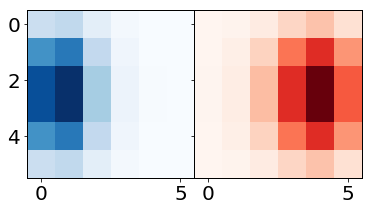

In [16]:
# map onto a 2d grid last eigenvector

eigenvec = eigenvectors[:, -1]

list_pop_donor =  get_list_population(integration_list_donor, eigenvec)
list_pop_acceptor =  get_list_population(integration_list_acceptor, eigenvec)
ipr_donor = calc_ipr(list_pop_donor)
ipr_acceptor = calc_ipr(list_pop_acceptor)
print "IPR donor", ipr_donor
print "IPR acceptor", ipr_acceptor

print "EIGENVAL:", eigenvalues[-1]
    

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.subplots_adjust(wspace=0)
ax1 = axs[0]
n= Ncells_y # site along one dimension
array_pop = np.array(list_pop_donor)
chunks_donor = [array_pop[i:i + n] for i in xrange(0, len(array_pop), n)]
#print np.array(chunks)

ax1.imshow(np.array(chunks_donor).T, cmap="Blues")

ax2 = axs[1]
n= Ncells_y
array_pop = np.array(list_pop_acceptor)
chunks_acceptor = [array_pop[i:i + n] for i in xrange(0, len(array_pop), n)]
#print np.array(chunks)

ax2.imshow(np.array(chunks_acceptor).T, cmap="Reds")
ax2.set_yticklabels([])

plt.show()

[1.0053857912461781, 1.8162489770285142, 1.8025385491623405, 1.9897349771356914, 2.4683930438628372, 2.2973361476967504, 2.6124588715982542, 3.350945156038299, 3.5608854317340963, 3.1890245693072807, 4.0085464985105608, 4.7222721098932894, 5.841099332354303, 4.6023545726811639, 5.6129825309089707, 6.533773992642673, 5.8178765518102358, 5.8206027844517862, 5.4671007961008575, 7.2206383057348038, 6.9610840624922279, 7.3985163679376118, 7.8644475366265576, 7.6604367936458102, 8.0029110124641569, 8.1846359563041791, 6.0687903658672626, 6.9004963046095398, 7.4867529487610298, 8.0793554761225739, 5.4103847726587588, 8.6213302109814602, 8.1756991165265571, 8.3672697879788114, 7.9290153084230282, 7.6396945129734659, 7.924863269951099, 9.3678866340068172, 8.2898235529199269, 4.7742662763770953, 8.8989996999035323, 8.711422530528063, 6.5018734513779757, 8.3432639422110828, 8.5161852296961804, 5.7955133686920286, 6.0148487287834298, 8.1880573715609284, 5.268369999751692, 6.7706356382665227, 7.927

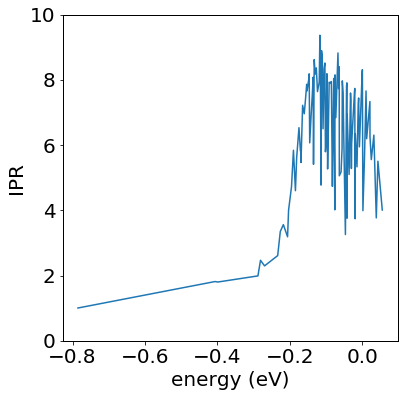

[1.0211777340493986, 2.0203350205059398, 2.0624101079508113, 2.5749203877922247, 3.4349471259733755, 3.0501835027589479, 2.9998402125148411, 5.2458250696168394, 5.5649889171105666, 4.975161889050181, 3.652815703438657, 7.1446521285198683, 7.7962759982629439, 4.2904076527099724, 7.4368067002336122, 8.6973971732483815, 8.3687960091107598, 4.9127422630210935, 8.2343190055799944, 8.5520259391961631, 9.2421841290756621, 8.7872565047064324, 8.8211519961515954, 6.6417828204602278, 8.2536457984872715, 9.3531467762310818, 9.4280056839779185, 8.6182785752849131, 8.8575547732358419, 8.4140922865088186, 7.3267414805272013, 9.2213327858724519, 8.8458747716993802, 7.9384610988196451, 9.0727530304209107, 8.9189666714620994, 8.8496350198368923, 9.2040155549306117, 9.5620886764382753, 7.1354735985614246, 9.6632353284156949, 9.2034726447293469, 8.3178657356965608, 9.2375708645264627, 9.1000131776053674, 8.8420673331904194, 8.91881004871877, 9.1420865816638344, 8.3851722281301626, 9.1974037762003285, 8.8

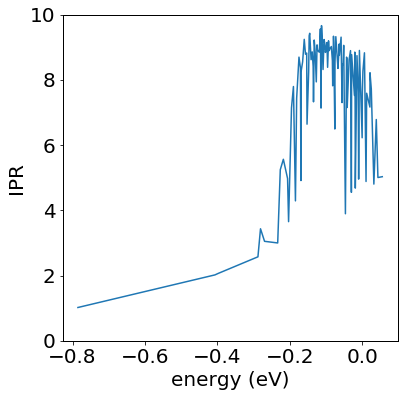

In [10]:

# calc energy resolved IPR

list_iprs = []
for eigenv in eigenvectors.T: # you need to transpose it to get the columns
    list_pop_donor =  get_list_population(integration_list_donor, eigenv)
    ipr = 0
    for pop in list_pop_donor:
        ipr += pop**2
    ipr = 1/ipr
    list_iprs.append(ipr)
print list_iprs

plt.plot(eigenvalues, list_iprs)



plt.ylim([0,10])
plt.xlabel("energy (eV)")
plt.ylabel("IPR")
plt.show()

list_iprs = []
for eigenv in eigenvectors.T: # you need to transpose it to get the columns
    list_pop_acceptor =  get_list_population(integration_list_acceptor, eigenv)
    ipr = 0
    for pop in list_pop_acceptor:
        ipr += pop**2
    ipr = 1/ipr
    list_iprs.append(ipr)
print list_iprs

plt.plot(eigenvalues, list_iprs)

plt.ylim([0,10])
plt.xlabel("energy (eV)")
plt.ylabel("IPR")
plt.show()
    

#plt.hist2d(eigenvalues, list_iprs)
#plt.show()


[ -7.85127562e-01  -4.06773910e-01  -3.98484280e-01  -2.88024176e-01
  -2.80943678e-01  -2.69761755e-01  -2.33467978e-01  -2.26296655e-01
  -2.17812501e-01  -2.06199663e-01  -2.03394205e-01  -1.95332936e-01
  -1.89974416e-01  -1.84459883e-01  -1.81095692e-01  -1.74704404e-01
  -1.70676529e-01  -1.69300844e-01  -1.69106751e-01  -1.64632560e-01
  -1.60134767e-01  -1.56710942e-01  -1.53396190e-01  -1.52446551e-01
  -1.47936650e-01  -1.46544668e-01  -1.45057431e-01  -1.41242198e-01
  -1.38146860e-01  -1.35545970e-01  -1.34574858e-01  -1.32596758e-01
  -1.29964898e-01  -1.26891821e-01  -1.24816120e-01  -1.23667854e-01
  -1.18801484e-01  -1.16919259e-01  -1.15601194e-01  -1.13764041e-01
  -1.12456599e-01  -1.10358756e-01  -1.08258781e-01  -1.05381253e-01
  -1.03140823e-01  -1.01652639e-01  -1.00026992e-01  -9.75350354e-02
  -9.56280019e-02  -9.31078244e-02  -9.13029130e-02  -8.89997680e-02
  -8.53065255e-02  -8.24304755e-02  -8.15601985e-02  -7.93467081e-02
  -7.87700529e-02  -7.56837003e-02

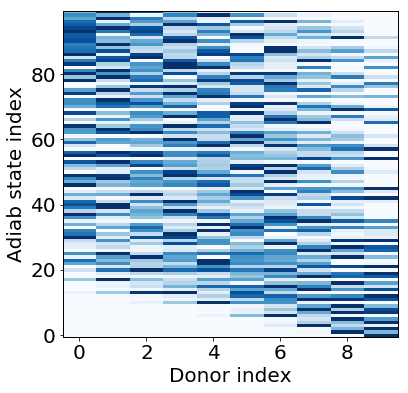

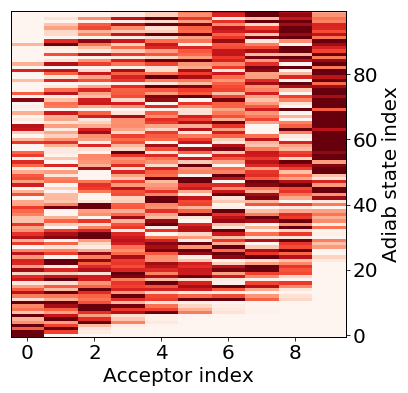

In [11]:
params = {
   'axes.labelsize': 20,
   'font.size': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': False,
   'figure.figsize': [6, 6],
    'axes.linewidth' : 1
   }
rcParams.update(params)


def get_list_population(integration_list, selected_eigen):
    """this works for both donor and acceptor 
    integration_list: pass the integration list created before for
        donor or acceptor phases
    selected_eigen: is one of the eigenvector
    
    """
    
    list_pop_donor = []
    for donor_list in integration_list:
        pop = 0.0
        for mol_ind in donor_list:
            pop += selected_eigen[mol_ind]**2
        list_pop_donor.append(pop)
    return list_pop_donor

def calc_ipr(list_pop):
    ipr = 0
    for pop in list_pop:
        ipr += pop**2
    ipr = 1/ipr
    return ipr

freq_plot = 1

last_eigen = False

#loop and select few eigenvectors
print eigenvalues[::freq_plot]
count = -1 
list_donor = []
energy = []
list_acceptor = []
for eigenvec in eigenvectors.T[::freq_plot]: # neeed to be transposer
    
    if last_eigen == True:
        eigenvec = eigenvectors[:, -1]
    
    # you could loop and calculate this for all the eigenvectors
    list_pop_donor =  get_list_population(integration_list_donor, eigenvec)
    list_pop_acceptor =  get_list_population(integration_list_acceptor, eigenvec)
    ipr_donor = calc_ipr(list_pop_donor)
    ipr_acceptor = calc_ipr(list_pop_acceptor)
    #print "IPR donor", ipr_donor
    #print "IPR acceptor", ipr_acceptor
    
    count += 1 
    #print "EIGENVAL:", eigenvalues[freq_plot*count]
    energy.append(eigenvalues[freq_plot*count])
    
    #test if populations sum to 1, acceptor population should sum to -1 you need to change sign
    #print np.sum(list_pop_donor)
    #print np.sum(list_pop_acceptor)
    
    n= Ncells_y # site along one dimension
    array_pop_donor = np.array(list_pop_donor)
    #print "array_pop_donor", array_pop_donor
    chunks_donor = [array_pop_donor[i:i + n] for i in xrange(0, len(array_pop_donor), n)]
    #print "SUM", np.sum(array_pop_donor)
    
    n= Ncells_y
    array_pop_accept = np.array(list_pop_acceptor)
    chunks_acceptor = [array_pop_accept[i:i + n] for i in xrange(0, len(array_pop_accept), n)]
    #print chunks_acceptor
    
    list_donor.append(array_pop_donor)
    list_acceptor.append(array_pop_accept)
    

#### PLOT DONOR INTEGRATED OVER ACCEPTOR #####
# NOTE: data is a 2by 2 array that has the population array of each state in each row itegrated over the other molecule
data = np.array(list_donor)
#normalized by row
norm_data = (data - np.min(data, axis=1)[:, np.newaxis]) / np.ptp(data, axis=1)[:, np.newaxis]

## not normalized stats
#fig, ax1 = plt.subplots()
#im1 = ax1.imshow(data, interpolation='none', cmap="Blues", aspect='auto', origin="lower")
#fig.colorbar(im1, ax=ax1, label='raw values')

# somehow normalized in each row
fig, ax2 = plt.subplots()
im2 = ax2.imshow(norm_data, interpolation='none', cmap="Blues", aspect='auto', origin="lower")
#fig.colorbar(im2, ax=ax2, label='normalized by row')

##### TO ADJUST #########################################
#ax1.set_yticks(list(np.arange(0,100,20)))  ## this is 100 states max
##convert x axis in Angstrom
#locs, labels = plt.yticks()
#print locs[1:]
#labels = [energy[int(item)] for item in locs[1:-1]]
#plt.yticks(locs, labels)

ax2.set_ylabel("Adiab state index")
ax2.set_xlabel("Donor index")
plt.show()


#### PLOT ACCEPTOR INTEGRATED OVER DONOR #####
# NOTE: data is a 2by 2 array that has the population array of each state in each row itegrated over the other molecule
data = np.array(list_acceptor)
#normalized by row
norm_data = (data - np.min(data, axis=1)[:, np.newaxis]) / np.ptp(data, axis=1)[:, np.newaxis]

## not normalized stats
#fig, ax1 = plt.subplots()
#im1 = ax1.imshow(data, interpolation='none', cmap="Blues", aspect='auto', origin="lower")
#fig.colorbar(im1, ax=ax1, label='raw values')

# somehow normalized in each row
fig, ax4 = plt.subplots()
im4 = ax4.imshow(norm_data, interpolation='none', cmap="Reds", aspect='auto', origin="lower")
#fig.colorbar(im4, ax=ax4, label='normalized by row')

#move stuff on the right 
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_ylabel("Adiab state index")
ax4.set_xlabel("Acceptor index")
plt.show()

In [180]:
np.arange(0,100,20)

array([ 0, 20, 40, 60, 80])

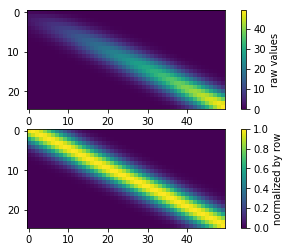

In [32]:
#test normalization
import numpy as np
import matplotlib.pyplot as plt


shifts = np.linspace(1, 50, 25)[:, np.newaxis]
x = np.arange(50)[np.newaxis, :]
data = np.exp(-(x - shifts)**2 / 50) * shifts

fig, (ax1, ax2) = plt.subplots(2, 1)

im1 = ax1.imshow(data, interpolation='none', cmap='viridis')
fig.colorbar(im1, ax=ax1, label='raw values')

norm_data = (data - np.min(data, axis=1)[:, np.newaxis]) / np.ptp(data, axis=1)[:, np.newaxis]
im2 = ax2.imshow(norm_data, interpolation='none', cmap='viridis')
fig.colorbar(im2, ax=ax2, label='normalized by row')

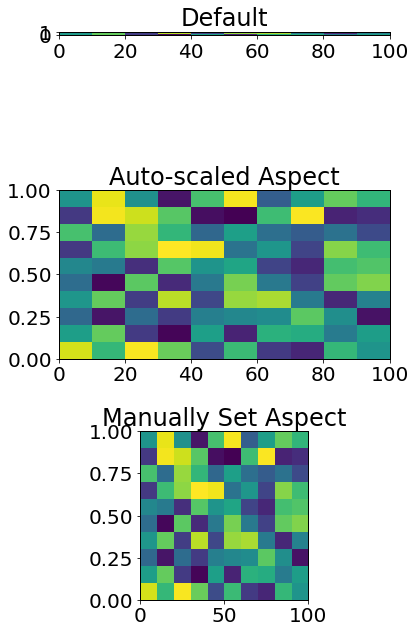

In [57]:
#test aspect ratio 
#https://stackoverflow.com/questions/13384653/imshow-extent-and-aspect

import matplotlib.pyplot as plt
import numpy as np

grid = np.random.random((10,10))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(6,10))

ax1.imshow(grid, extent=[0,100,0,1])
ax1.set_title('Default')

ax2.imshow(grid, extent=[0,100,0,1], aspect='auto')
ax2.set_title('Auto-scaled Aspect')

ax3.imshow(grid, extent=[0,100,0,1], aspect=100)
ax3.set_title('Manually Set Aspect')

plt.tight_layout()
plt.show()

[[-0.12        0.1         0.         ...,  0.          0.          0.        ]
 [ 0.1        -0.11907335  0.1        ...,  0.          0.          0.        ]
 [ 0.          0.1        -0.1164171  ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ..., -0.1164171   0.1         0.        ]
 [ 0.          0.          0.         ...,  0.1        -0.11907335  0.1       ]
 [ 0.          0.          0.         ...,  0.          0.1        -0.12      ]]
SHAPE (4096, 4096)
[-1.20045771 -1.18217604 -1.15406376 ...,  0.61229287  0.61715035
  0.64809282]
4096
2048
2048


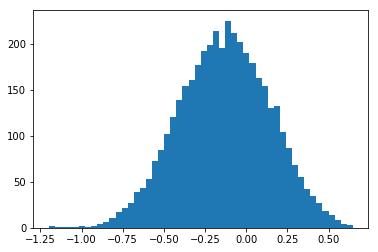

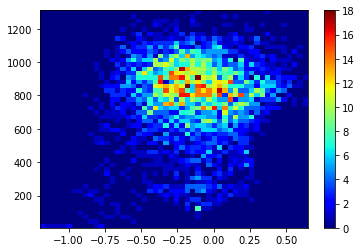

In [104]:

print eigenvalues
last_eigen = eigenvectors[:, 0]
print len(last_eigen)



pos = [i for i in last_eigen if i >= 0]
print len(pos)
neg = [i for i in last_eigen if i <= 0]
print len(neg)

plt.hist(eigenvalues, 50)
plt.show()


adiab_ipr = _calc_IPR_for_Adiabats(eigenvectors)
plt.hist2d(eigenvalues, adiab_ipr, bins=(50, 50), cmap=plt.cm.jet)
#plt.hist(adiab_ipr, 50)
plt.colorbar()
plt.show()

1.0
[[  3.36003752e-12   1.38394583e-11   2.86876470e-11   3.98018125e-11
    3.98018125e-11   2.86876470e-11   1.38394583e-11   3.36003752e-12]
 [  1.07692936e-10   4.54684946e-10   9.55224763e-10   1.33075735e-09
    1.33075735e-09   9.55224763e-10   4.54684946e-10   1.07692936e-10]
 [  3.13990820e-09   1.36912580e-08   2.92007783e-08   4.08367318e-08
    4.08367318e-08   2.92007783e-08   1.36912580e-08   3.13990820e-09]
 [  8.73368804e-08   3.96825557e-07   8.60129379e-07   1.20680773e-06
    1.20680773e-06   8.60129379e-07   3.96825557e-07   8.73368804e-08]
 [  2.26913476e-06   1.08763141e-05   2.39802990e-05   3.37390529e-05
    3.37390529e-05   2.39802990e-05   1.08763141e-05   2.26913476e-06]
 [  5.26209999e-05   2.70746321e-04   6.07698049e-04   8.57225455e-04
    8.57225455e-04   6.07698049e-04   2.70746321e-04   5.26209999e-05]
 [  9.79784522e-04   5.55143959e-03   1.26964725e-02   1.79637011e-02
    1.79637011e-02   1.26964725e-02   5.55143959e-03   9.79784522e-04]
 [  1.042

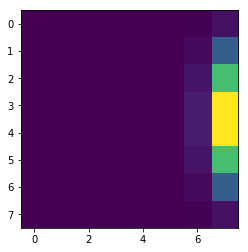

In [105]:
lst = list(last_eigen)
n=64

chunks = [lst[i:i + n] for i in xrange(0, len(lst), n)]

array_pop = []
for state in chunks:
    pop = np.sum(np.array(state)**2)
    array_pop.append(pop)
    
print np.sum(array_pop)
n= 8
chunks = [array_pop[i:i + n] for i in xrange(0, len(array_pop), n)]
print np.array(chunks)

plt.imshow(np.array(chunks).T)
plt.show()

In [2]:
import numpy as np

donor = [1,2]
acceptor = [3,4,5]

connectivity  =[
    [1,2, 1],
    [1,3, 1],
    [3,4, 1], 
    [4,5, 1]     
     
]

states = []
for i in donor:
    for j in acceptor:
        couple = [i,j]
        states.append(couple)
print states

print len(states)

hamilt =  np.zeros([len(states),len(states)])

i = -1
for s1 in states:
    i +=1 
    j = i -1
    for s2 in states[i:]:
        j+=1
        #print i, j
        #print s1, s2
        if s1 != s2:
            if s2[0] == s1[0] and s2[1] == s1[1]+1:
                hamilt[i,j] = 2.0
            elif s2[1] == s1[1] and s2[0] == s1[0]+1:
                hamilt[i,j] = 1.0
            
        hamilt[j,i] = hamilt[i,j]
        
print hamilt

[[1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5]]
6
[[ 0.  2.  0.  1.  0.  0.]
 [ 2.  0.  2.  0.  1.  0.]
 [ 0.  2.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  2.  0.]
 [ 0.  1.  0.  2.  0.  2.]
 [ 0.  0.  1.  0.  2.  0.]]


In [3]:
donor = [1,2]
acceptor = [3,4,5]

connectivity  =[
    [1,2, 1],
    [1,3, 1],
    [3,4, 1], 
    [4,5, 1]     
     
]

print connectivity
states = []
for i in donor:
    for j in acceptor:
        couple = [i,j]
        states.append(couple)
print states

print len(states)

hamilt =  np.zeros([len(states),len(states)])

i = -1
for s1 in states:
    i +=1 
    j = i -1
    for s2 in states[i:]:
        j+=1
        #print i, j
        #print s1, s2
        if s1 != s2:
            print s1, s2
            for il in connectivity:
                if s2[0] == s1[0] and [s1[1],s2[1]] == [il[0],il[1]]:
                    hamilt[i,j] = 2.0
                elif s2[1] == s1[1] and [s1[0],s2[0]] == [il[0],il[1]]:
                    hamilt[i,j] = 1.0
            
        hamilt[j,i] = hamilt[i,j]
        
print hamilt

[[1, 2, 1], [1, 3, 1], [3, 4, 1], [4, 5, 1]]
[[1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5]]
6
[1, 3] [1, 4]
[1, 3] [1, 5]
[1, 3] [2, 3]
[1, 3] [2, 4]
[1, 3] [2, 5]
[1, 4] [1, 5]
[1, 4] [2, 3]
[1, 4] [2, 4]
[1, 4] [2, 5]
[1, 5] [2, 3]
[1, 5] [2, 4]
[1, 5] [2, 5]
[2, 3] [2, 4]
[2, 3] [2, 5]
[2, 4] [2, 5]
[[ 0.  2.  0.  1.  0.  0.]
 [ 2.  0.  2.  0.  1.  0.]
 [ 0.  2.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  2.  0.]
 [ 0.  1.  0.  2.  0.  2.]
 [ 0.  0.  1.  0.  2.  0.]]


In [4]:
# connectivity and donor/acceptor list depend on the order. 

donor = [4,3]
acceptor = [1,2,5]

connectivity  =[
    [4,3, 1],
    [1,4, 1],
    [1,2, 1], 
    [2,5, 1]     
     
]

print connectivity
states = []
for i in donor:
    for j in acceptor:
        couple = [i,j]
        states.append(couple)
print states
print len(states)

hamilt =  np.zeros([len(states),len(states)])

i = -1
for s1 in states:
    i +=1 
    j = i -1
    for s2 in states[i:]:
        j+=1
        #print i, j
        #print s1, s2
        if s1 != s2:
            print s1, s2
            for il in connectivity:
                if s2[0] == s1[0] and [s1[1],s2[1]] == [il[0],il[1]]:
                    hamilt[i,j] = 2.0
                elif s2[1] == s1[1] and [s1[0],s2[0]] == [il[0],il[1]]:
                    hamilt[i,j] = 1.0
            
        hamilt[j,i] = hamilt[i,j]
        
print hamilt

[[4, 3, 1], [1, 4, 1], [1, 2, 1], [2, 5, 1]]
[[4, 1], [4, 2], [4, 5], [3, 1], [3, 2], [3, 5]]
6
[4, 1] [4, 2]
[4, 1] [4, 5]
[4, 1] [3, 1]
[4, 1] [3, 2]
[4, 1] [3, 5]
[4, 2] [4, 5]
[4, 2] [3, 1]
[4, 2] [3, 2]
[4, 2] [3, 5]
[4, 5] [3, 1]
[4, 5] [3, 2]
[4, 5] [3, 5]
[3, 1] [3, 2]
[3, 1] [3, 5]
[3, 2] [3, 5]
[[ 0.  2.  0.  1.  0.  0.]
 [ 2.  0.  2.  0.  1.  0.]
 [ 0.  2.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  2.  0.]
 [ 0.  1.  0.  2.  0.  2.]
 [ 0.  0.  1.  0.  2.  0.]]


In [8]:
# connectivity and donor/acceptor list depend on the order. 

donor = [1,2,3,4]
acceptor = [5,6,7,8]

connectivity  =[
    [1,3, 1],
    [1,2, 1],
#    [1,4, 1], 
#    [2,3, 1],
    [2,4, 1],
    [3,4, 1],
    [3,5, 1],
#    [3,6, 1],
#    [4,5, 1],
    [4,6, 1],
    [5,6, 1],
    [5,7, 1],
#    [5,8, 1],
    [6,8, 1],
#    [6,7, 1],
    [7,8, 1],
     
]

print connectivity
states = []
for i in donor:
    for j in acceptor:
        couple = [i,j]
        states.append(couple)
print states
print len(states)

hamilt =  np.zeros([len(states),len(states)])

i = -1
for s1 in states:
    i +=1 
    j = i -1
    for s2 in states[i:]:
        j+=1
        #print i, j
        #print s1, s2
        if s1 != s2:
            print s1, s2
            # one index needs to be the same and the other a nearest neigbour (becuase only these states have non-zero V)
            for il in connectivity:
                if s2[0] == s1[0] and [s1[1],s2[1]] == [il[0],il[1]]:
                    hamilt[i,j] = 2.0
                elif s2[1] == s1[1] and [s1[0],s2[0]] == [il[0],il[1]]:
                    hamilt[i,j] = 1.0
            
        hamilt[j,i] = hamilt[i,j]
        
print hamilt
eigenvalues, eigenvectors = get_eigen( hamilt )

print eigenvalues

[[1, 3, 1], [1, 2, 1], [2, 4, 1], [3, 4, 1], [3, 5, 1], [4, 6, 1], [5, 6, 1], [5, 7, 1], [6, 8, 1], [7, 8, 1]]
[[1, 5], [1, 6], [1, 7], [1, 8], [2, 5], [2, 6], [2, 7], [2, 8], [3, 5], [3, 6], [3, 7], [3, 8], [4, 5], [4, 6], [4, 7], [4, 8]]
16
[1, 5] [1, 6]
[1, 5] [1, 7]
[1, 5] [1, 8]
[1, 5] [2, 5]
[1, 5] [2, 6]
[1, 5] [2, 7]
[1, 5] [2, 8]
[1, 5] [3, 5]
[1, 5] [3, 6]
[1, 5] [3, 7]
[1, 5] [3, 8]
[1, 5] [4, 5]
[1, 5] [4, 6]
[1, 5] [4, 7]
[1, 5] [4, 8]
[1, 6] [1, 7]
[1, 6] [1, 8]
[1, 6] [2, 5]
[1, 6] [2, 6]
[1, 6] [2, 7]
[1, 6] [2, 8]
[1, 6] [3, 5]
[1, 6] [3, 6]
[1, 6] [3, 7]
[1, 6] [3, 8]
[1, 6] [4, 5]
[1, 6] [4, 6]
[1, 6] [4, 7]
[1, 6] [4, 8]
[1, 7] [1, 8]
[1, 7] [2, 5]
[1, 7] [2, 6]
[1, 7] [2, 7]
[1, 7] [2, 8]
[1, 7] [3, 5]
[1, 7] [3, 6]
[1, 7] [3, 7]
[1, 7] [3, 8]
[1, 7] [4, 5]
[1, 7] [4, 6]
[1, 7] [4, 7]
[1, 7] [4, 8]
[1, 8] [2, 5]
[1, 8] [2, 6]
[1, 8] [2, 7]
[1, 8] [2, 8]
[1, 8] [3, 5]
[1, 8] [3, 6]
[1, 8] [3, 7]
[1, 8] [3, 8]
[1, 8] [4, 5]
[1, 8] [4, 6]
[1, 8] [4, 7]
[1, 8] [4, 8]
[